In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import calendar
import warnings
warnings.filterwarnings("ignore")
from IPython.display import display
from pylab import rcParams
import itertools

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import statsmodels.tools.eval_measures as em
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

In [2]:
sparkling_df = pd.read_csv("D:/DataSets/Sparkling.csv",parse_dates=["YearMonth"], index_col="YearMonth")
sparkling_df.head(10)

Sparkling
YearMonth            
1980-01-01       1686
1980-02-01       1591
1980-03-01       2304
1980-04-01       1712
1980-05-01       1471
1980-06-01       1377
1980-07-01       1966
1980-08-01       2453
1980-09-01       1984
1980-10-01       2596

In [3]:
sparkling_df.tail(10)

Sparkling
YearMonth            
1994-10-01       3385
1994-11-01       3729
1994-12-01       5999
1995-01-01       1070
1995-02-01       1402
1995-03-01       1897
1995-04-01       1862
1995-05-01       1670
1995-06-01       1688
1995-07-01       2031

In [4]:
dates = pd.date_range(start='1980-01-01', freq='MS', periods=len(sparkling_df))
sparkling_df['Month'] = dates.month
sparkling_df['Month'] = sparkling_df['Month'].apply(lambda x: calendar.month_abbr[x])
sparkling_df['Year'] = dates.year
sparkling_df.head(10)

Sparkling Month  Year
YearMonth                        
1980-01-01       1686   Jan  1980
1980-02-01       1591   Feb  1980
1980-03-01       2304   Mar  1980
1980-04-01       1712   Apr  1980
1980-05-01       1471   May  1980
1980-06-01       1377   Jun  1980
1980-07-01       1966   Jul  1980
1980-08-01       2453   Aug  1980
1980-09-01       1984   Sep  1980
1980-10-01       2596   Oct  1980

In [5]:
sparkling_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 187 entries, 1980-01-01 to 1995-07-01
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sparkling  187 non-null    int64 
 1   Month      187 non-null    object
 2   Year       187 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 5.8+ KB


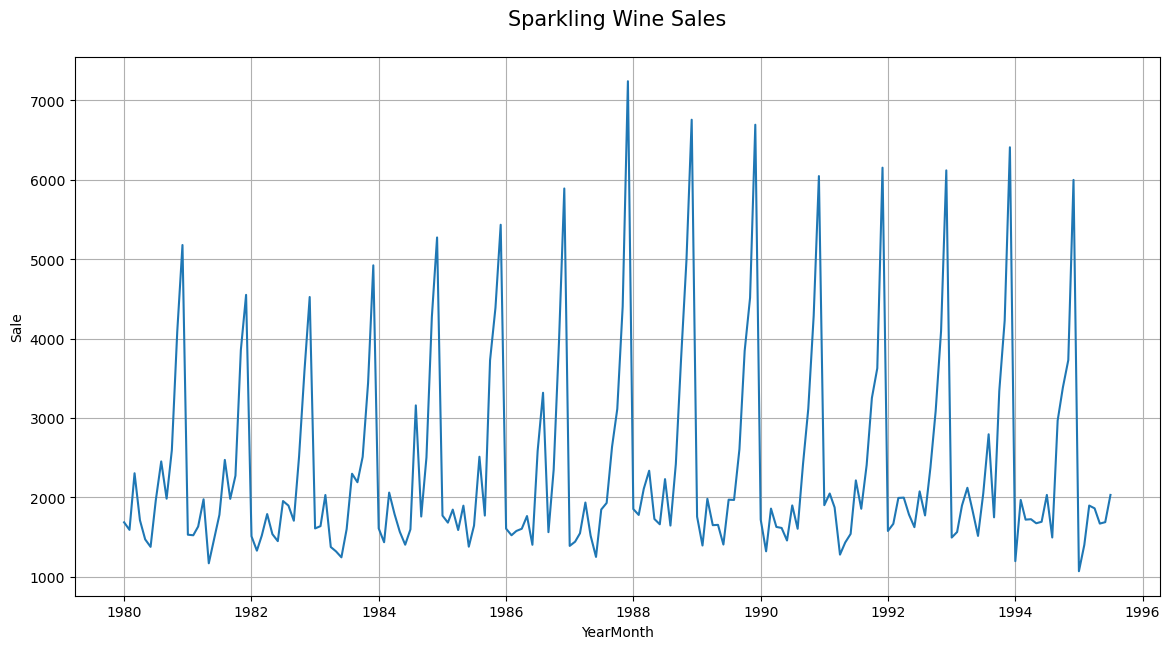

In [6]:
plt.figure(figsize=(14,7))
sns.lineplot(sparkling_df["Sparkling"])
plt.title("Sparkling Wine Sales\n",fontsize=15)
plt.ylabel("Sale")
plt.grid()

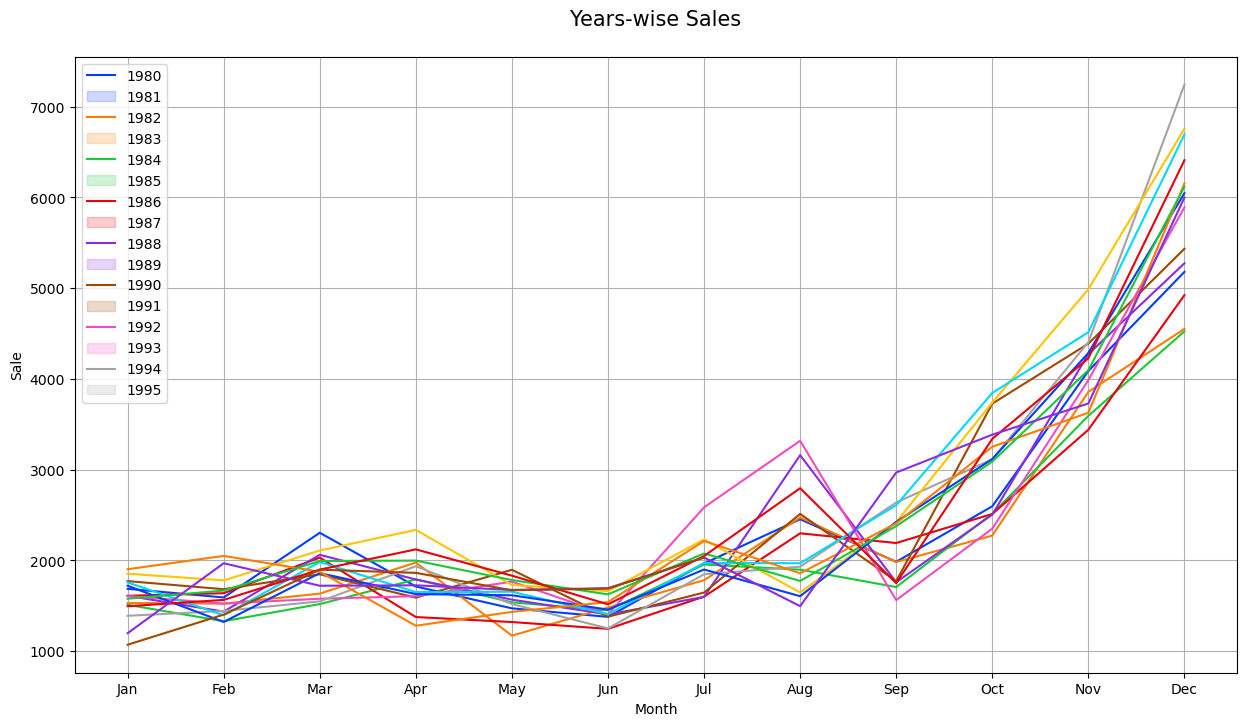

In [7]:
plt.figure(figsize=(15,8))
sns.lineplot(sparkling_df,x="Month",y="Sparkling",hue="Year",palette="bright")
plt.title("Years-wise Sales\n",fontsize=15)
plt.ylabel("Sale")
plt.legend(sparkling_df["Year"].unique())
plt.grid()

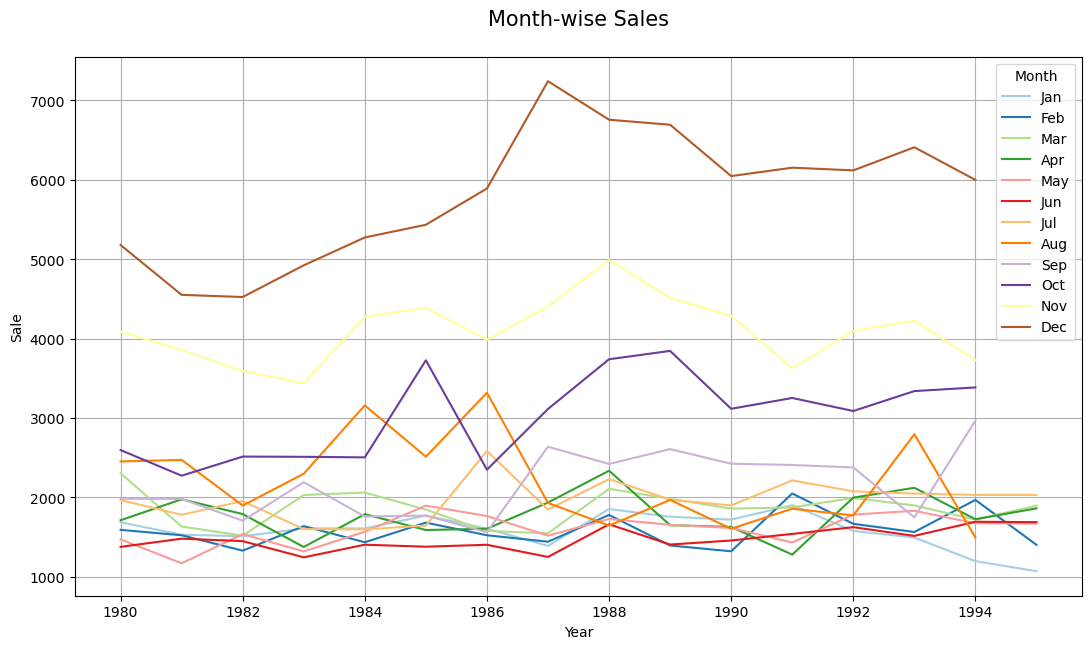

In [8]:
plt.figure(figsize=(13,7))
sns.lineplot(sparkling_df,x="Year",y="Sparkling",hue="Month",palette="Paired")
plt.title("Month-wise Sales\n",fontsize=15)
plt.ylabel("Sale")
plt.grid()

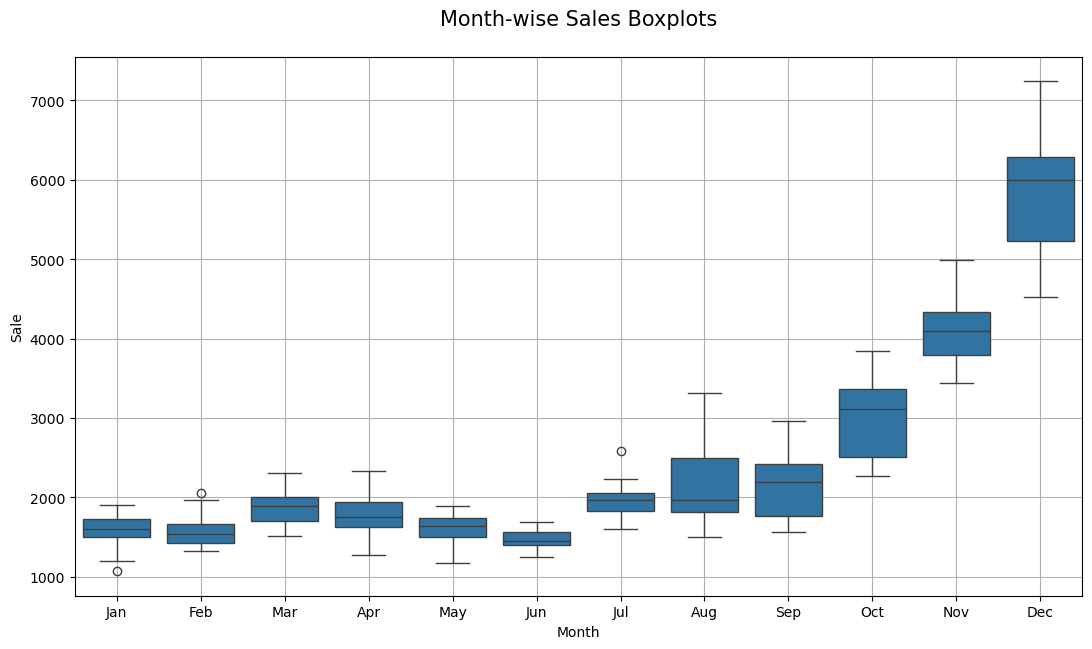

In [9]:
plt.figure(figsize=(13,7))
sns.boxplot(sparkling_df,x="Month",y="Sparkling")
plt.title("Month-wise Sales Boxplots\n",fontsize=15)
plt.ylabel("Sale")
plt.grid()

### Inference
- The Sparkling Wine Sales trend steadily increases up until the year 1988, where the sale was the highest followed by a steady decline up until the year 1995.
- 12-month seasonality is prominent in the dataset
- Looking at the yearly and monthly sales plots, it can be clearly noted that certain months have much higher wine sales in comparison to the rest
- Up until the month of August, the sale is within the limits of 1000 to 3000 units
- From September onwards, the sale shoots exponentially and the month of December aces the wine sales throughout the years with an upper limit of approximately 7000 units

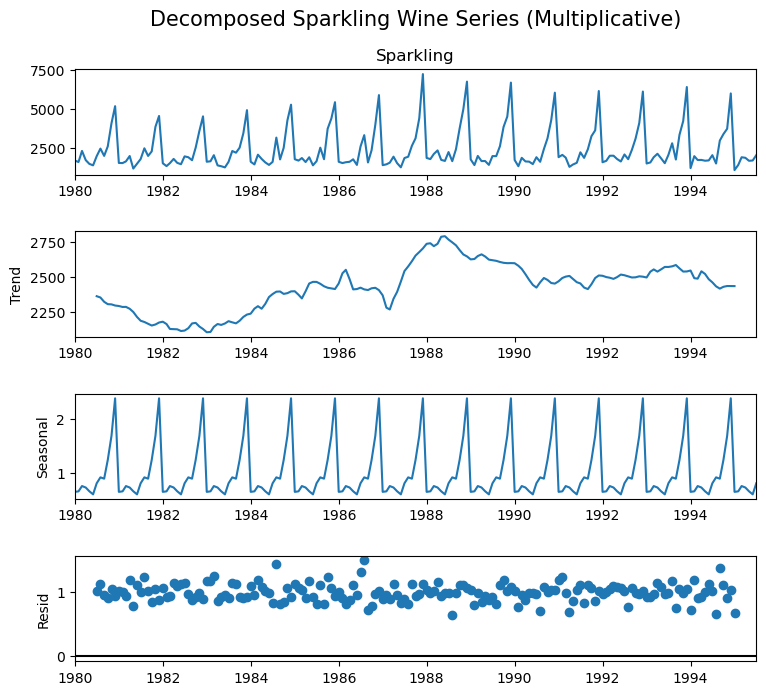

In [10]:
decomposition = seasonal_decompose(sparkling_df["Sparkling"],model="multiplicative")
fig = decomposition.plot()
fig.set_figwidth(8)
fig.set_figheight(7)
plt.title('Decomposed Sparkling Wine Series (Multiplicative)\n\n',fontsize=15,y=5.5)
plt.show()

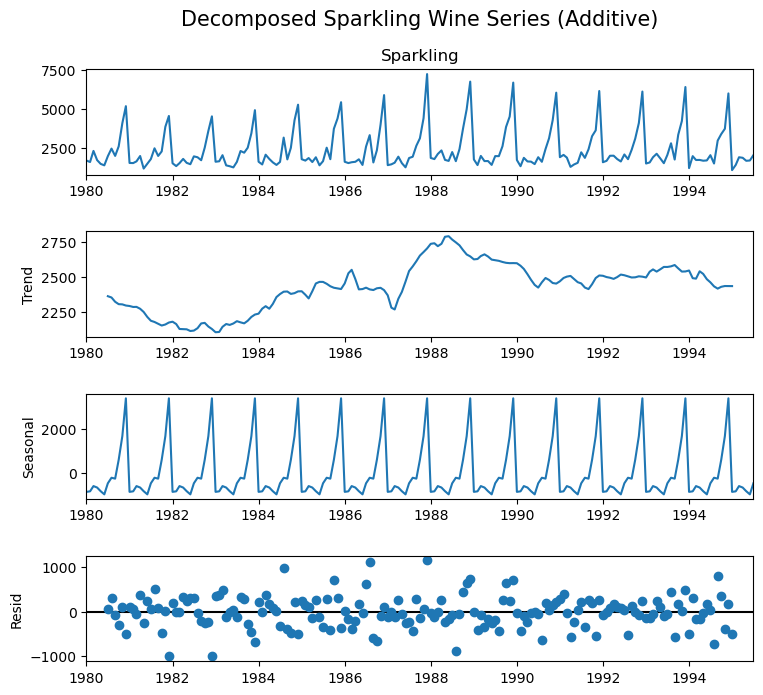

In [11]:
decomposition = seasonal_decompose(sparkling_df["Sparkling"],model="additive")
fig = decomposition.plot()
fig.set_figwidth(8)
fig.set_figheight(7)
plt.title('Decomposed Sparkling Wine Series (Additive)\n\n',fontsize=15,y=5.5)
plt.show()

<b> Multiplicative decomposition seems to be more appropriate due to the scattered and non-uniform distribution of the residual values

## Model Building
### Test-Train Split

In [12]:
train    =   sparkling_df[0:int(len(sparkling_df)*0.7)] 
test     =   sparkling_df[int(len(sparkling_df)*0.7):]

In [13]:
print("Train dataset tail:")
format(display(train.tail()))
print("\n\nTest dataset head:")
format(display(test.head()))

Train dataset tail:


Sparkling Month  Year
YearMonth                        
1990-06-01       1457   Jun  1990
1990-07-01       1899   Jul  1990
1990-08-01       1605   Aug  1990
1990-09-01       2424   Sep  1990
1990-10-01       3116   Oct  1990



Test dataset head:


Sparkling Month  Year
YearMonth                        
1990-11-01       4286   Nov  1990
1990-12-01       6047   Dec  1990
1991-01-01       1902   Jan  1991
1991-02-01       2049   Feb  1991
1991-03-01       1874   Mar  1991

'None'

<b> Test dataset consists of sales values from the year 1990. Determining the index of the train dataset in order to include the sales values from the year 1991.

In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 130 entries, 1980-01-01 to 1990-10-01
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sparkling  130 non-null    int64 
 1   Month      130 non-null    object
 2   Year       130 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 4.1+ KB


In [15]:
train = sparkling_df[:132]
test = sparkling_df[132:]

print("Train dataset tail:")
format(display(train.tail()))
print("\n\nTest dataset head:")
format(display(test.head()))

Train dataset tail:


Sparkling Month  Year
YearMonth                        
1990-08-01       1605   Aug  1990
1990-09-01       2424   Sep  1990
1990-10-01       3116   Oct  1990
1990-11-01       4286   Nov  1990
1990-12-01       6047   Dec  1990



Test dataset head:


Sparkling Month  Year
YearMonth                        
1991-01-01       1902   Jan  1991
1991-02-01       2049   Feb  1991
1991-03-01       1874   Mar  1991
1991-04-01       1279   Apr  1991
1991-05-01       1432   May  1991

'None'

<b> Test dataset now consists of the sales value from the year 1991.

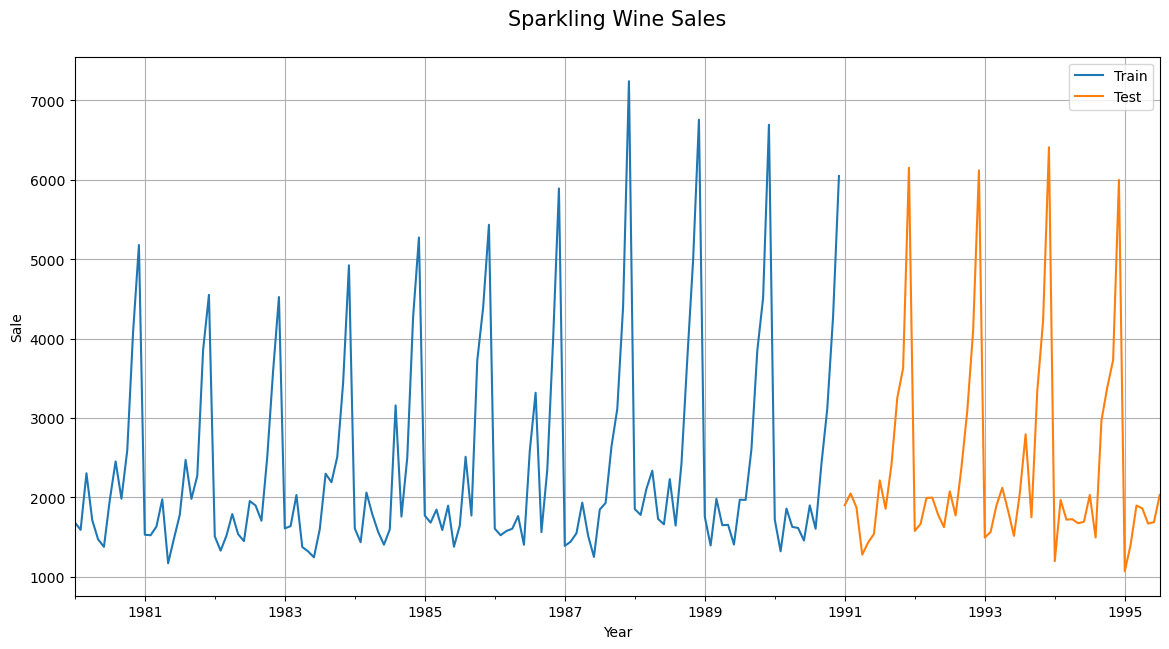

In [16]:
plt.figure(figsize=(14,7))
train["Sparkling"].plot()
test["Sparkling"].plot()
plt.title("Sparkling Wine Sales\n",fontsize=15)
plt.ylabel("Sale")
plt.xlabel("Year")
plt.legend(["Train","Test"])
plt.grid()

### Model 1 - Linear Regression

<b> Modifying the train dataset by introducing a time variable before fitting it into a linear regression model.

In [17]:
print("Shape of train data: {}\nShape of test data: {}\n".format(train.shape,test.shape))

Shape of train data: (132, 3)
Shape of test data: (55, 3)



In [18]:
train_time = [i+1 for i in range(len(train))]
test_time = [i+131 for i in range(len(test))]
print('Training Time instance','\n',train_time)
print('Test Time instance','\n',test_time)

Training Time instance 
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132]
Test Time instance 
 [131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185]


In [19]:
LR_train = train.copy()
LR_test = test.copy()

In [20]:
LR_train['Time'] = train_time
LR_test['Time'] = test_time

print('First few rows of Training Data')
display(LR_train.head())
print('Last few rows of Training Data')
display(LR_train.tail())
print('First few rows of Test Data')
display(LR_test.head())
print('Last few rows of Test Data')
display(LR_test.tail())

First few rows of Training Data


Sparkling Month  Year  Time
YearMonth                              
1980-01-01       1686   Jan  1980     1
1980-02-01       1591   Feb  1980     2
1980-03-01       2304   Mar  1980     3
1980-04-01       1712   Apr  1980     4
1980-05-01       1471   May  1980     5

Last few rows of Training Data


Sparkling Month  Year  Time
YearMonth                              
1990-08-01       1605   Aug  1990   128
1990-09-01       2424   Sep  1990   129
1990-10-01       3116   Oct  1990   130
1990-11-01       4286   Nov  1990   131
1990-12-01       6047   Dec  1990   132

First few rows of Test Data


Sparkling Month  Year  Time
YearMonth                              
1991-01-01       1902   Jan  1991   131
1991-02-01       2049   Feb  1991   132
1991-03-01       1874   Mar  1991   133
1991-04-01       1279   Apr  1991   134
1991-05-01       1432   May  1991   135

Last few rows of Test Data


Sparkling Month  Year  Time
YearMonth                              
1995-03-01       1897   Mar  1995   181
1995-04-01       1862   Apr  1995   182
1995-05-01       1670   May  1995   183
1995-06-01       1688   Jun  1995   184
1995-07-01       2031   Jul  1995   185

<b> Building the Linear Regression model now that the dataset has been modified.

In [21]:
lr = LinearRegression()
lr.fit(LR_train[['Time']],LR_train['Sparkling'])

LinearRegression()

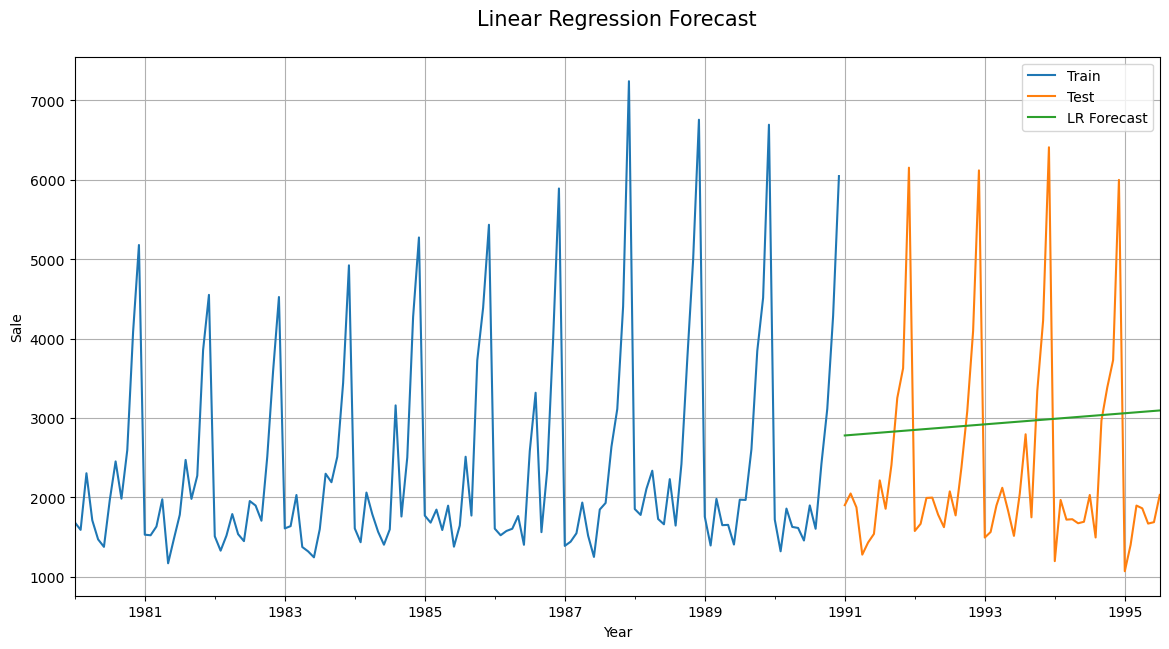

In [22]:
lr_train_predictions = lr.predict(LR_train[['Time']])
LR_train['RegOnTime'] = lr_train_predictions

lr_test_predictions = lr.predict(LR_test[['Time']])
LR_test['RegOnTime'] = lr_test_predictions

plt.figure(figsize=(14,7))
train["Sparkling"].plot()
test["Sparkling"].plot()
LR_test["RegOnTime"].plot()
plt.title("Linear Regression Forecast\n",fontsize=15)
plt.legend(["Train","Test","LR Forecast"])
plt.xlabel("Year")
plt.ylabel("Sale")
plt.grid()

<b> It can be visually observed that the predictions made by the Linear Regression model are not accurate.

<b> Model Evaluation

In [23]:
rmse_lr =mean_squared_error(test['Sparkling'],lr_test_predictions,squared=False)
print("For Linear Regression forecast on the Test Data,  RMSE is %3.3f " %(rmse_lr))

For Linear Regression forecast on the Test Data,  RMSE is 1384.558 


### Creating a dataframe to store the RMSE scores of all the models

In [24]:
rmse_scores = pd.DataFrame(columns=["Model","RMSE"])

rmse_lr = pd.DataFrame([["LinearRegression",round(rmse_lr,2)]],columns=rmse_scores.columns)
rmse_scores = pd.concat([rmse_scores,rmse_lr],ignore_index=True)
rmse_scores

Model     RMSE
0  LinearRegression  1384.56

### Model 2: Naive Approach

<b> Applying the Naive-based Approach which assumes that the prediction for the next day is the present day. This also means that the prediction for the 2nd day in future is the same as the present day. Hence the actual value for the present day can be assigned as the predicted values to all the future days to come.

In [25]:
NaiveModel_train = train.copy()
NaiveModel_test = test.copy()

In [26]:
train.tail()

Sparkling Month  Year
YearMonth                        
1990-08-01       1605   Aug  1990
1990-09-01       2424   Sep  1990
1990-10-01       3116   Oct  1990
1990-11-01       4286   Nov  1990
1990-12-01       6047   Dec  1990

#### Assigning the last actual value of the train set as the predicted values for all the values in the test set

In [27]:
NaiveModel_test['naive'] = np.asarray(train['Sparkling'])[len(np.asarray(train['Sparkling']))-1]
NaiveModel_test.head()

Sparkling Month  Year  naive
YearMonth                               
1991-01-01       1902   Jan  1991   6047
1991-02-01       2049   Feb  1991   6047
1991-03-01       1874   Mar  1991   6047
1991-04-01       1279   Apr  1991   6047
1991-05-01       1432   May  1991   6047

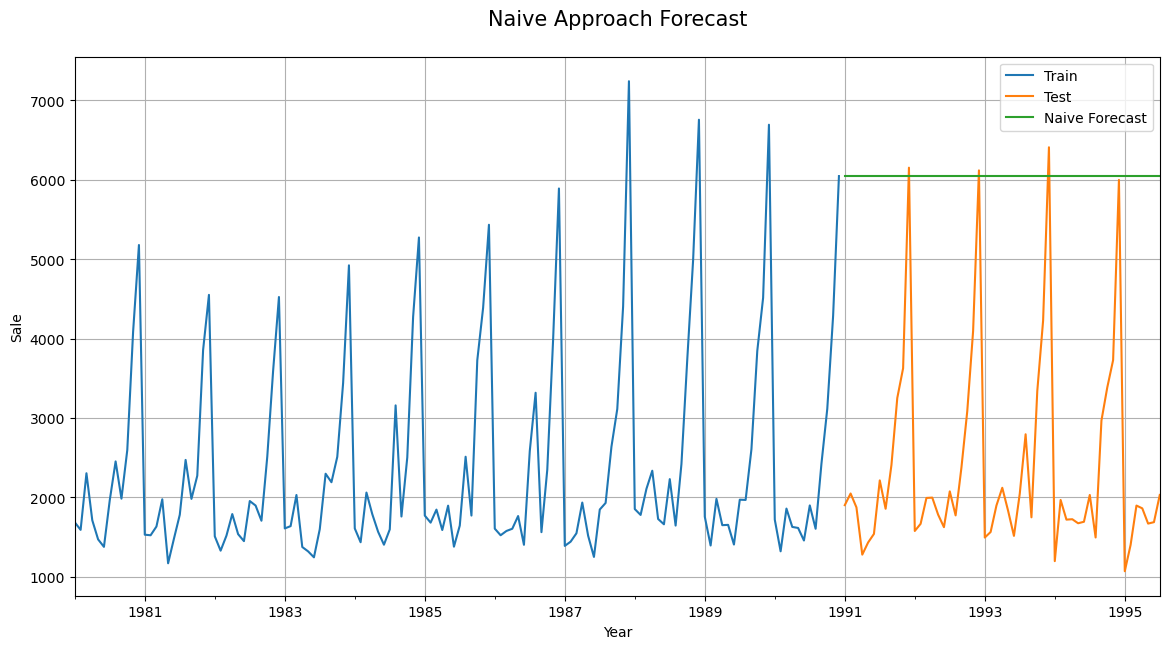

In [28]:
plt.figure(figsize=(14,7))
train["Sparkling"].plot()
test["Sparkling"].plot()
NaiveModel_test["naive"].plot()
plt.legend(["Train","Test","Naive Forecast"])
plt.title("Naive Approach Forecast\n",fontsize=15)
plt.xlabel("Year")
plt.ylabel("Sale")
plt.grid()

<b> Model Evaluation

In [29]:
rmse_naive = mean_squared_error(test['Sparkling'],NaiveModel_test['naive'],squared=False)
print("For Naive Forecast on the Test Data,  RMSE is %3.3f" %(rmse_naive))

For Naive Forecast on the Test Data,  RMSE is 3864.279


In [30]:
rmse_naive= pd.DataFrame([["Naive",round(rmse_naive,2)]],columns=rmse_scores.columns)
rmse_scores = pd.concat([rmse_scores,rmse_naive],ignore_index=True)
rmse_scores

Model     RMSE
0  LinearRegression  1384.56
1             Naive  3864.28

### Model 3: Simple Average

<b> The average values of the training set will be used for the forecast of the test values in this model.

In [31]:
SimpleAverage_train = train.copy()
SimpleAverage_test = test.copy()

In [32]:
SimpleAverage_test['mean_forecast'] = train['Sparkling'].mean()
SimpleAverage_test.head()

Sparkling Month  Year  mean_forecast
YearMonth                                       
1991-01-01       1902   Jan  1991    2403.780303
1991-02-01       2049   Feb  1991    2403.780303
1991-03-01       1874   Mar  1991    2403.780303
1991-04-01       1279   Apr  1991    2403.780303
1991-05-01       1432   May  1991    2403.780303

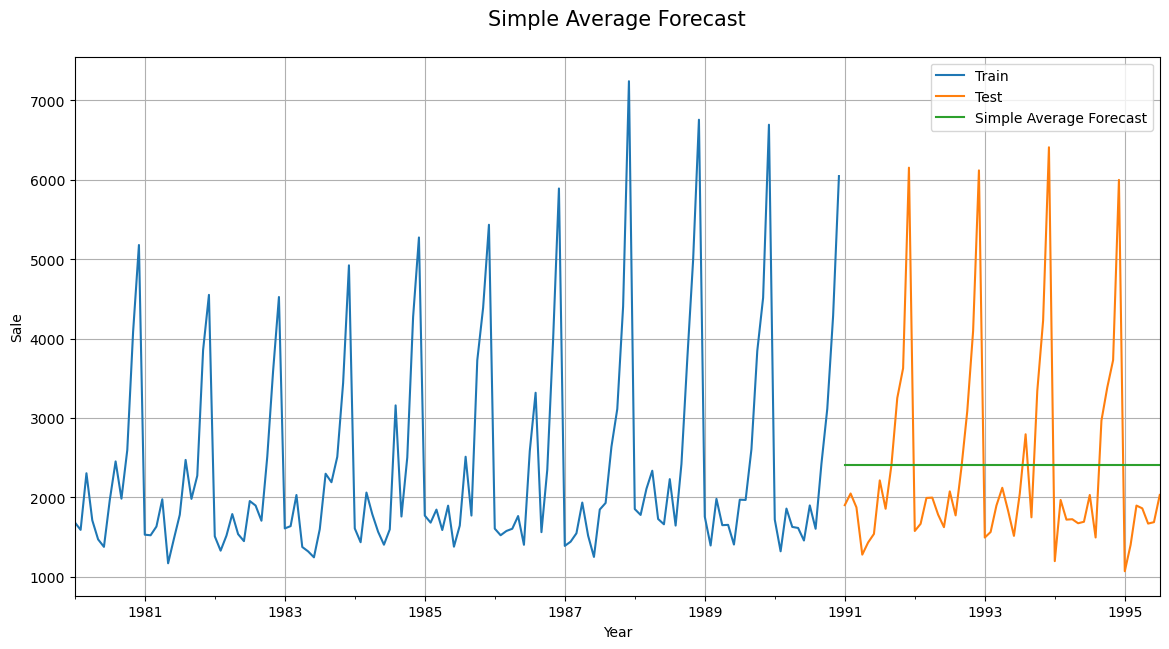

In [33]:
plt.figure(figsize=(14,7))
train["Sparkling"].plot()
test["Sparkling"].plot()
SimpleAverage_test["mean_forecast"].plot()
plt.legend(["Train","Test","Simple Average Forecast"])
plt.title("Simple Average Forecast\n",fontsize=15)
plt.xlabel("Year")
plt.ylabel("Sale")
plt.grid()

<b> Model Evaluation

In [34]:
rmse_SA = mean_squared_error(test['Sparkling'],SimpleAverage_test['mean_forecast'],squared=False)
print("For Simple Average forecast on the Test Data,  RMSE is %3.3f" %(rmse_SA))

For Simple Average forecast on the Test Data,  RMSE is 1275.082


In [35]:
rmse_SA= pd.DataFrame([["SimpleAverage",round(rmse_SA,2)]],columns=rmse_scores.columns)
rmse_scores = pd.concat([rmse_scores,rmse_SA],ignore_index=True)
rmse_scores = rmse_scores.sort_values(by="RMSE")
rmse_scores

Model     RMSE
2     SimpleAverage  1275.08
0  LinearRegression  1384.56
1             Naive  3864.28

### Model 4: Moving Average(MA)

<b> The rolling means or moving averages will be used for the forecast of the test values in this model. The moving averages are calculated for the entire dataset.

In [36]:
MovingAverage = sparkling_df.copy()
MovingAverage.head()

Sparkling Month  Year
YearMonth                        
1980-01-01       1686   Jan  1980
1980-02-01       1591   Feb  1980
1980-03-01       2304   Mar  1980
1980-04-01       1712   Apr  1980
1980-05-01       1471   May  1980

<b> Trailing moving averages

In [37]:
MovingAverage['Trailing_2'] = MovingAverage['Sparkling'].rolling(2).mean()
MovingAverage['Trailing_4'] = MovingAverage['Sparkling'].rolling(4).mean()
MovingAverage['Trailing_6'] = MovingAverage['Sparkling'].rolling(6).mean()
MovingAverage['Trailing_9'] = MovingAverage['Sparkling'].rolling(9).mean()

MovingAverage.head()

Sparkling Month  Year  Trailing_2  Trailing_4  Trailing_6  \
YearMonth                                                               
1980-01-01       1686   Jan  1980         NaN         NaN         NaN   
1980-02-01       1591   Feb  1980      1638.5         NaN         NaN   
1980-03-01       2304   Mar  1980      1947.5         NaN         NaN   
1980-04-01       1712   Apr  1980      2008.0     1823.25         NaN   
1980-05-01       1471   May  1980      1591.5     1769.50         NaN   

            Trailing_9  
YearMonth               
1980-01-01         NaN  
1980-02-01         NaN  
1980-03-01         NaN  
1980-04-01         NaN  
1980-05-01         NaN

#### Plotting on the whole data

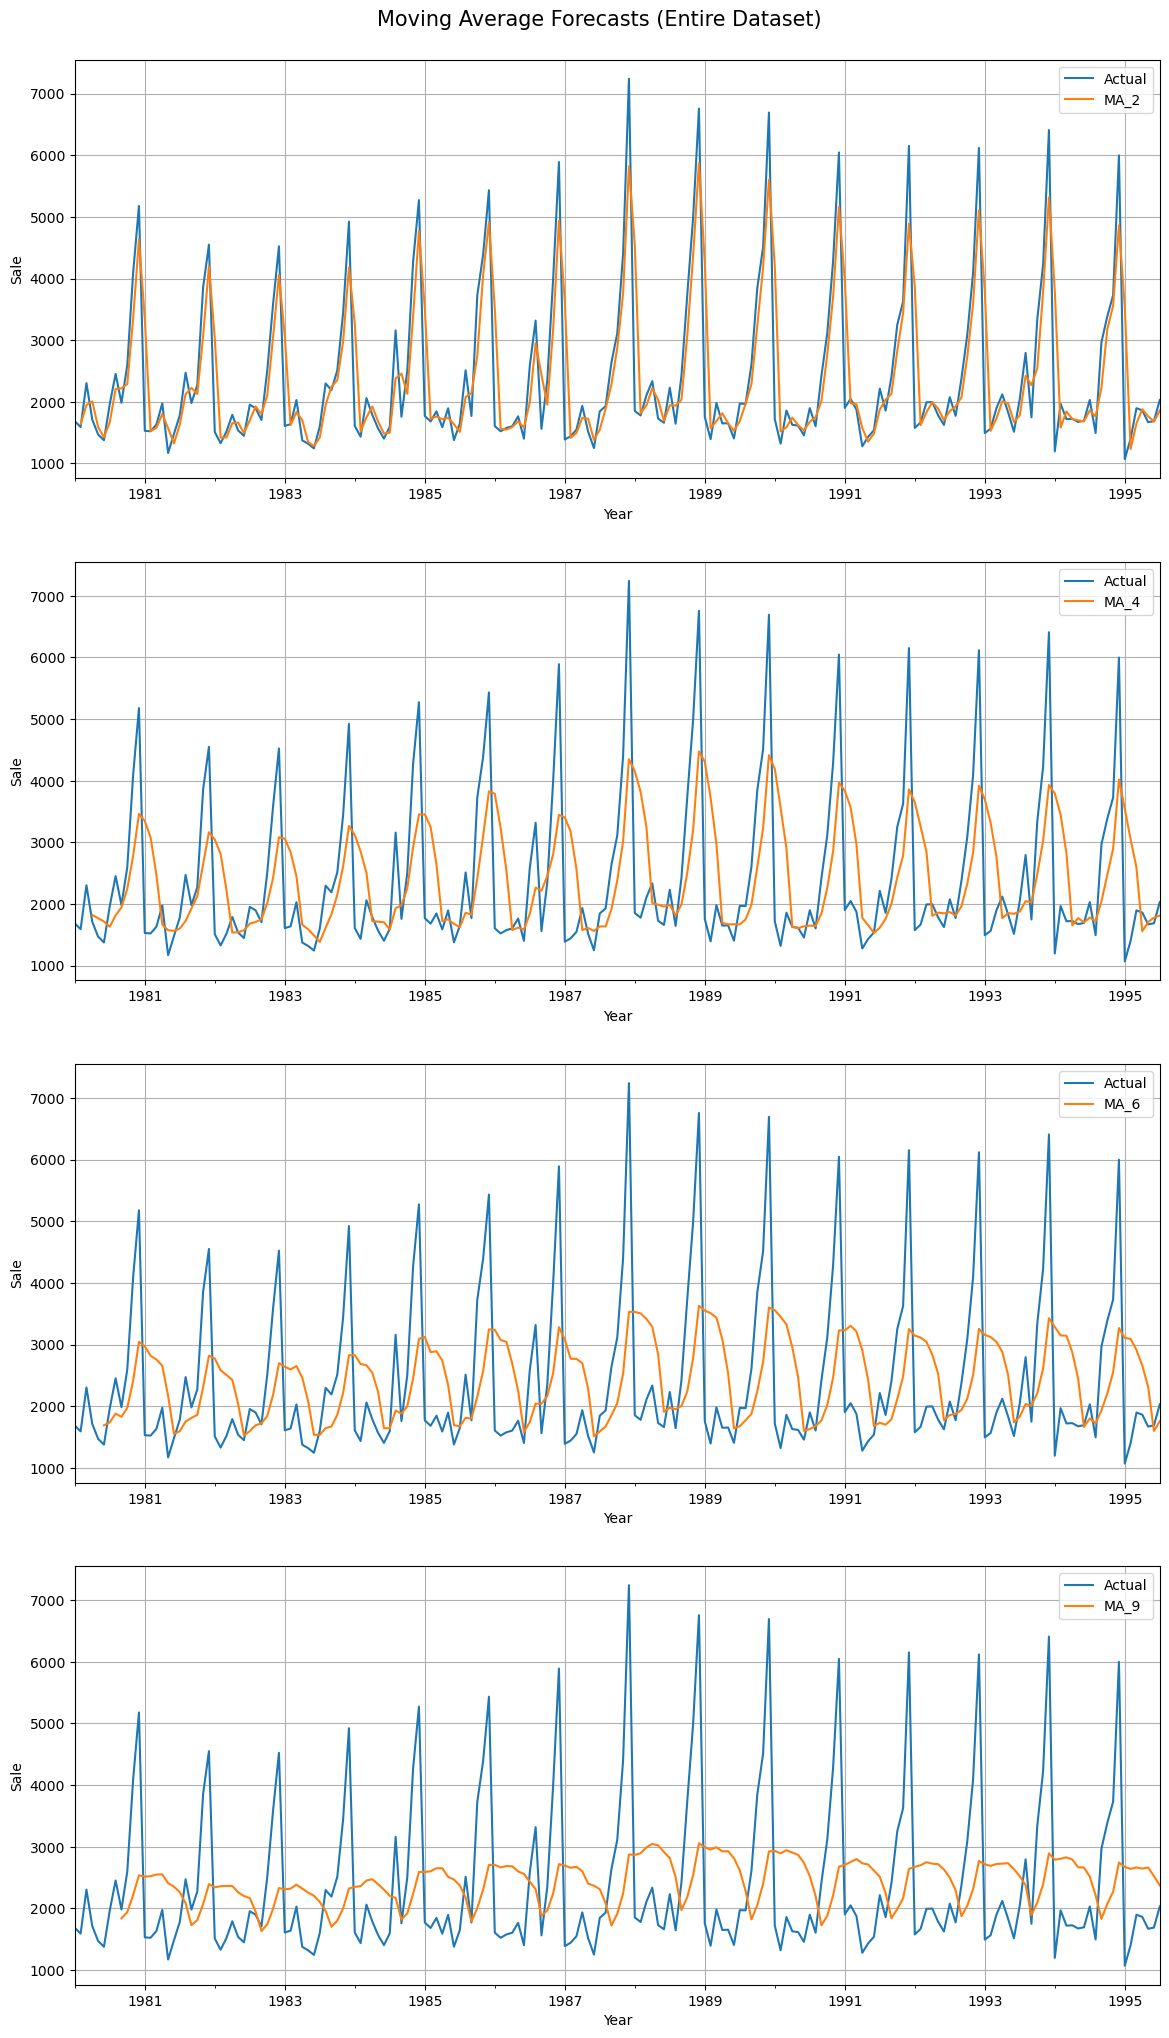

In [38]:
fig, ax = plt.subplots(4, 1, figsize=(14,25))

plt.suptitle("Moving Average Forecasts (Entire Dataset)",fontsize=15,y=0.9)

MovingAverage["Sparkling"].plot(ax=ax[0])
MovingAverage["Trailing_2"].plot(ax=ax[0],label='2 Point Moving Average')
ax[0].legend(["Actual","MA_2"])

MovingAverage["Sparkling"].plot(ax=ax[1])
MovingAverage["Trailing_4"].plot(ax=ax[1],label='4 Point Moving Average')
ax[1].legend(["Actual","MA_4"])

MovingAverage["Sparkling"].plot(ax=ax[2])
MovingAverage["Trailing_6"].plot(ax=ax[2],label='6 Point Moving Average')
ax[2].legend(["Actual","MA_6"])

MovingAverage["Sparkling"].plot(ax=ax[3])
MovingAverage["Trailing_9"].plot(ax=ax[3],label='9 Point Moving Average')
ax[3].legend(["Actual","MA_9"])

for axes in ax:
    axes.set_xlabel("Year")
    axes.set_ylabel("Sale")
    axes.grid()

<b> Splitting the moving average data into train and test set as per the previous train-test split.

In [39]:
trailing_MovingAverage_train=MovingAverage[:132] 
trailing_MovingAverage_test=MovingAverage[132:]
trailing_MovingAverage_test.head()

Sparkling Month  Year  Trailing_2  Trailing_4   Trailing_6  \
YearMonth                                                                
1991-01-01       1902   Jan  1991      3974.5     3837.75  3230.000000   
1991-02-01       2049   Feb  1991      1975.5     3571.00  3304.000000   
1991-03-01       1874   Mar  1991      1961.5     2968.00  3212.333333   
1991-04-01       1279   Apr  1991      1576.5     1776.00  2906.166667   
1991-05-01       1432   May  1991      1355.5     1658.50  2430.500000   

             Trailing_9  
YearMonth                
1991-01-01  2705.666667  
1991-02-01  2753.888889  
1991-03-01  2800.222222  
1991-04-01  2731.333333  
1991-05-01  2712.111111

#### Plotting on the Test data

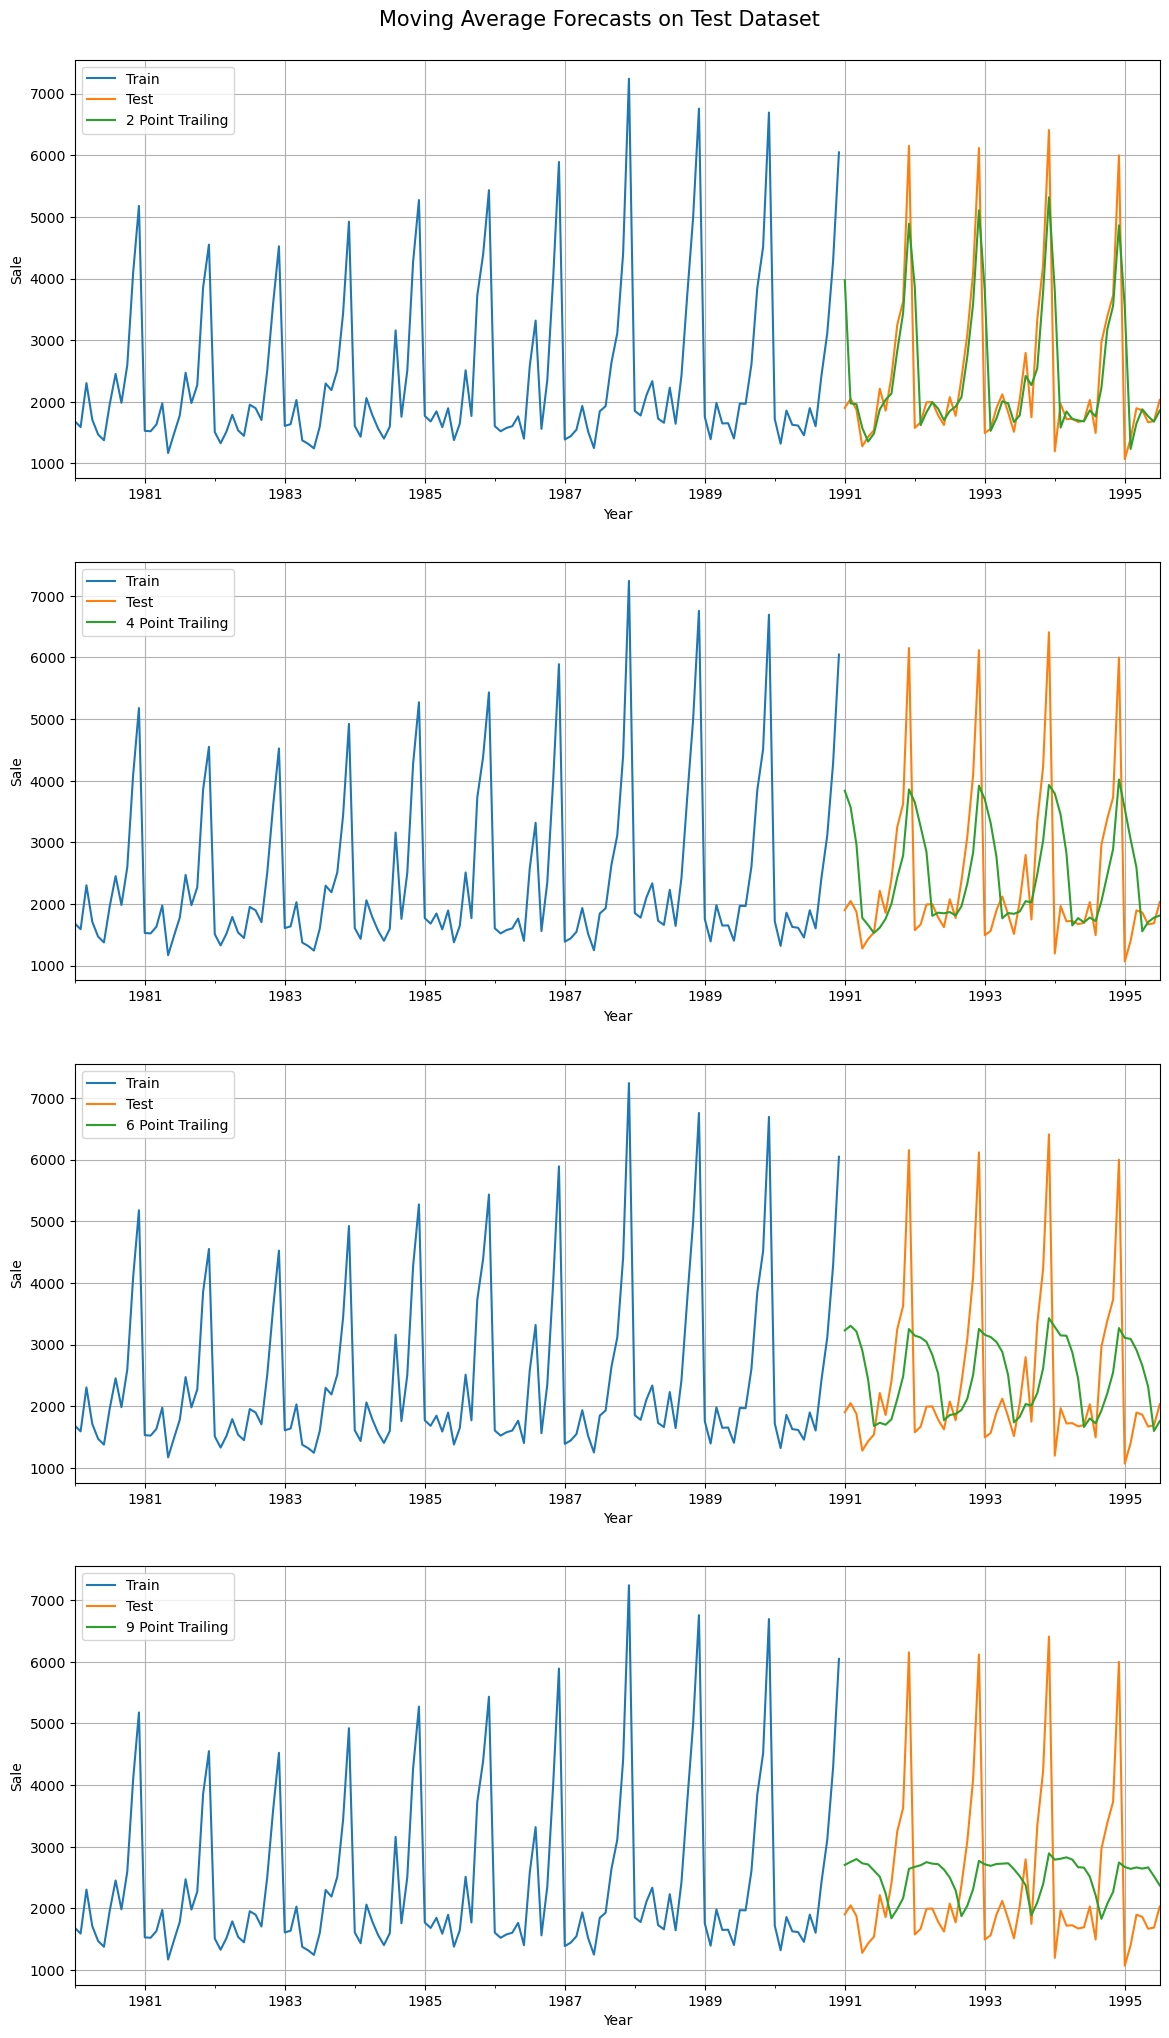

In [40]:
fig, ax = plt.subplots(4, 1, figsize=(14,25))

plt.suptitle("Moving Average Forecasts on Test Dataset",fontsize=15,y=0.9)

train["Sparkling"].plot(ax=ax[0])
test["Sparkling"].plot(ax=ax[0])
trailing_MovingAverage_test['Trailing_2'].plot(ax=ax[0])
ax[0].legend(["Train","Test","2 Point Trailing"])

train["Sparkling"].plot(ax=ax[1])
test["Sparkling"].plot(ax=ax[1])
trailing_MovingAverage_test['Trailing_4'].plot(ax=ax[1])
ax[1].legend(["Train","Test","4 Point Trailing"])

train["Sparkling"].plot(ax=ax[2])
test["Sparkling"].plot(ax=ax[2])
trailing_MovingAverage_test['Trailing_6'].plot(ax=ax[2])
ax[2].legend(["Train","Test","6 Point Trailing"])

train["Sparkling"].plot(ax=ax[3])
test["Sparkling"].plot(ax=ax[3])
trailing_MovingAverage_test['Trailing_9'].plot(ax=ax[3])
ax[3].legend(["Train","Test","9 Point Trailing"])

for axes in ax:
    axes.set_xlabel("Year")
    axes.set_ylabel("Sale")
    axes.grid()

<b> Model Evaluation (Test Data)

In [41]:
#2-point Trailing MA

MA_2_rmse = mean_squared_error(test['Sparkling'],trailing_MovingAverage_test['Trailing_2'],squared=False)
print("For 2 point Moving Average Model forecast on the Test Data,  RMSE is %3.3f" %(MA_2_rmse))

#4-point Trailing MA

MA_4_rmse = mean_squared_error(test['Sparkling'],trailing_MovingAverage_test['Trailing_4'],squared=False)
print("For 4 point Moving Average Model forecast on the Test Data,  RMSE is %3.3f" %(MA_4_rmse))
      
#6-point Trailing MA

MA_6_rmse = mean_squared_error(test['Sparkling'],trailing_MovingAverage_test['Trailing_6'],squared=False)
print("For 6 point Moving Average Model forecast on the Test Data,  RMSE is %3.3f" %(MA_6_rmse))
      
#9-point Trailing MA

MA_9_rmse = mean_squared_error(test['Sparkling'],trailing_MovingAverage_test['Trailing_9'],squared=False)
print("For 9 point Moving Average Model forecast on the Test Data,  RMSE is %3.3f" %(MA_9_rmse))

For 2 point Moving Average Model forecast on the Test Data,  RMSE is 813.401
For 4 point Moving Average Model forecast on the Test Data,  RMSE is 1156.590
For 6 point Moving Average Model forecast on the Test Data,  RMSE is 1283.927
For 9 point Moving Average Model forecast on the Test Data,  RMSE is 1346.278


In [42]:
rmse_MA = pd.DataFrame([["2-PointMovingAverage",round(MA_2_rmse,2)],
                        ["4-PointMovingAverage",round(MA_4_rmse,2)],
                        ["6-PointMovingAverage",round(MA_9_rmse,2)],
                        ["9-PointMovingAverage",round(MA_9_rmse,2)]],columns=rmse_scores.columns)

rmse_scores = pd.concat([rmse_scores,rmse_MA],ignore_index=True)
rmse_scores = rmse_scores.sort_values(by="RMSE")
rmse_scores

Model     RMSE
3  2-PointMovingAverage   813.40
4  4-PointMovingAverage  1156.59
0         SimpleAverage  1275.08
5  6-PointMovingAverage  1346.28
6  9-PointMovingAverage  1346.28
1      LinearRegression  1384.56
2                 Naive  3864.28

#### Plotting all the models on the test data

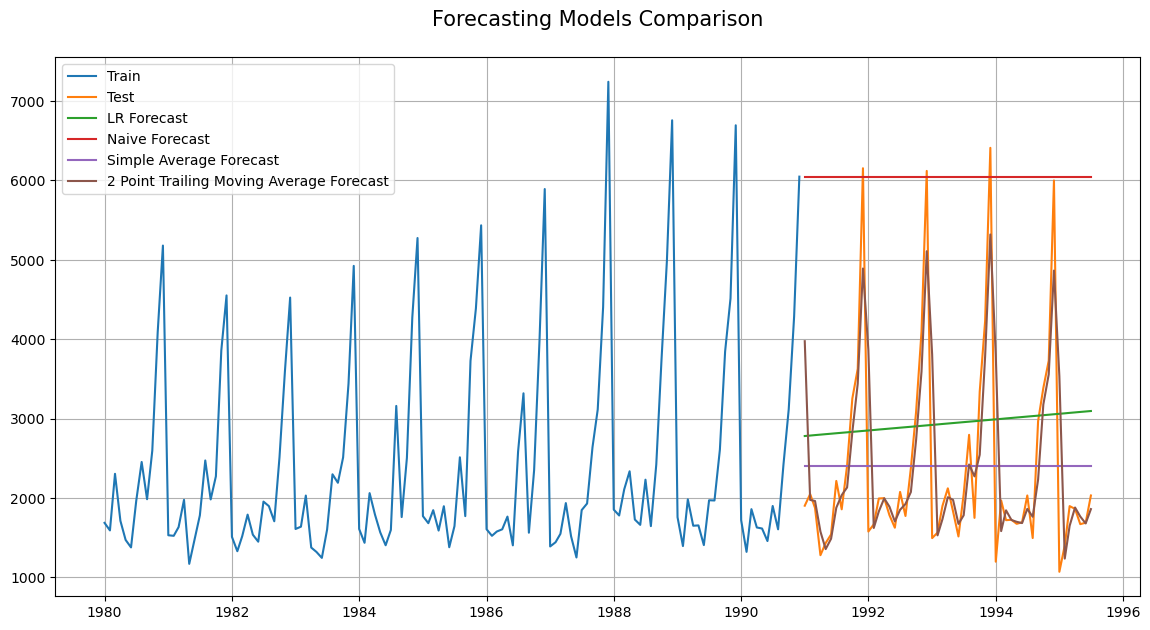

In [43]:
plt.figure(figsize=(14,7))
plt.plot(train['Sparkling'], label='Train')
plt.plot(test['Sparkling'], label='Test')

plt.plot(LR_test['RegOnTime'], label='LR Forecast')
plt.plot(NaiveModel_test['naive'], label='Naive Forecast')
plt.plot(SimpleAverage_test['mean_forecast'], label='Simple Average Forecast')
plt.plot(trailing_MovingAverage_test['Trailing_2'], label='2 Point Trailing Moving Average Forecast')

plt.legend(loc='best')
plt.title("Forecasting Models Comparison\n",fontsize=15)
plt.grid();

### Model 5 - Simple Exponential Smoothing

In [44]:
model_SES = SimpleExpSmoothing(train["Sparkling"],initialization_method='estimated')
model_SES_autofit = model_SES.fit(optimized=True)

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


#### Checking the model parameters

In [45]:
model_SES_autofit.params

{'smoothing_level': 0.07028442075641193,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 1763.8402828521703,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

### Using the fitted model on the training set to forecast on the test set

<b> The smoothing level (&alpha;) has been taken very low at around 0.1.

In [46]:
SES_predict = model_SES_autofit.forecast(steps=len(test))
SES_predict.head()

1991-01-01    2804.650301
1991-02-01    2804.650301
1991-03-01    2804.650301
1991-04-01    2804.650301
1991-05-01    2804.650301
Freq: MS, dtype: float64

#### Plotting the Training data, Test data and the forecasted values

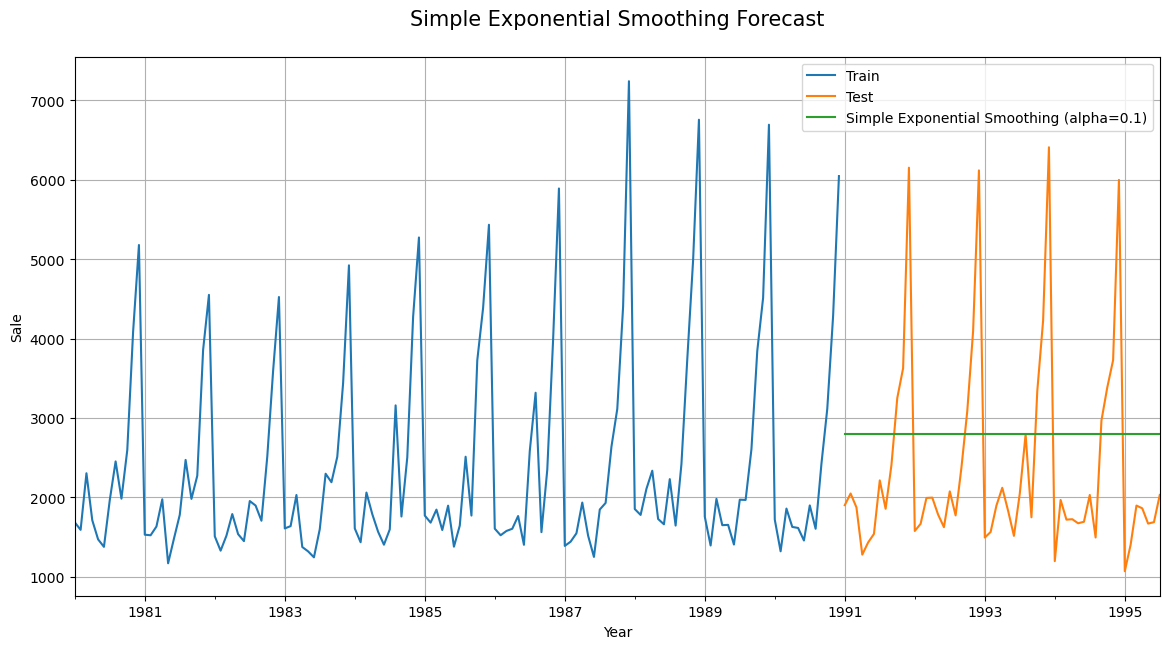

In [47]:
plt.figure(figsize=(14,7))
train["Sparkling"].plot()
test["Sparkling"].plot()
SES_predict.plot()
plt.legend(["Train","Test","Simple Exponential Smoothing (alpha=0.1)"])
plt.title("Simple Exponential Smoothing Forecast\n",fontsize=15)
plt.xlabel("Year")
plt.ylabel("Sale")
plt.grid()

<b> Model Evaluation

In [48]:
SES_rmse = mean_squared_error(test['Sparkling'],SES_predict.values,squared=False)
print("For Simple Exponential Smoothing Model forecast on the Test Data,  RMSE is %3.3f" %(SES_rmse))

For Simple Exponential Smoothing Model forecast on the Test Data,  RMSE is 1338.001


In [49]:
rmse_SES = pd.DataFrame([["SimpleExponentialSmoothing",round(SES_rmse,2)]],columns=rmse_scores.columns)

rmse_scores = pd.concat([rmse_scores,rmse_SES],ignore_index=True)
rmse_scores = rmse_scores.sort_values(by="RMSE")
rmse_scores

Model     RMSE
0        2-PointMovingAverage   813.40
1        4-PointMovingAverage  1156.59
2               SimpleAverage  1275.08
7  SimpleExponentialSmoothing  1338.00
3        6-PointMovingAverage  1346.28
4        9-PointMovingAverage  1346.28
5            LinearRegression  1384.56
6                       Naive  3864.28

### Model 6 - Double Exponential Smoothing

In [50]:
model_DES = Holt(train["Sparkling"],initialization_method='estimated')
model_DES = model_DES.fit()

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


#### Checking the model parameters

In [51]:
model_DES.params

{'smoothing_level': 0.6649999999999999,
 'smoothing_trend': 0.0001,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 1502.1999999999991,
 'initial_trend': 74.87272727272739,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

<b> The smoothing level ( $\alpha$ ) has been taken at around 0.6 while the smoothing trend ( $\beta$ ) is taken at 10<sup>-4</sup>.

In [52]:
DES_predict =  model_DES.forecast(len(test))
DES_predict

1991-01-01    5401.733026
1991-02-01    5476.005230
1991-03-01    5550.277433
1991-04-01    5624.549637
1991-05-01    5698.821840
1991-06-01    5773.094044
1991-07-01    5847.366248
1991-08-01    5921.638451
1991-09-01    5995.910655
1991-10-01    6070.182858
1991-11-01    6144.455062
1991-12-01    6218.727266
1992-01-01    6292.999469
1992-02-01    6367.271673
1992-03-01    6441.543876
1992-04-01    6515.816080
1992-05-01    6590.088284
1992-06-01    6664.360487
1992-07-01    6738.632691
1992-08-01    6812.904894
1992-09-01    6887.177098
1992-10-01    6961.449302
1992-11-01    7035.721505
1992-12-01    7109.993709
1993-01-01    7184.265912
1993-02-01    7258.538116
1993-03-01    7332.810320
1993-04-01    7407.082523
1993-05-01    7481.354727
1993-06-01    7555.626930
1993-07-01    7629.899134
1993-08-01    7704.171338
1993-09-01    7778.443541
1993-10-01    7852.715745
1993-11-01    7926.987948
1993-12-01    8001.260152
1994-01-01    8075.532356
1994-02-01    8149.804559
1994-03-01  

#### Plotting the Training data, Test data and the forecasted values

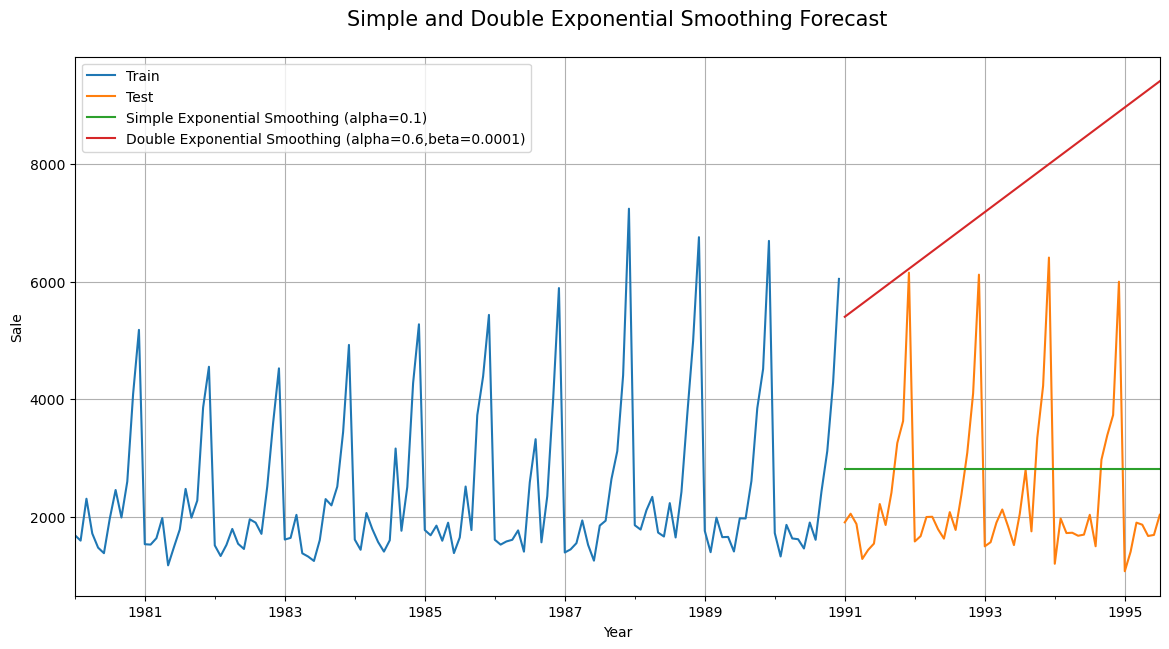

In [53]:
plt.figure(figsize=(14,7))
train["Sparkling"].plot()
test["Sparkling"].plot()
SES_predict.plot()
DES_predict.plot()
plt.legend(["Train","Test","Simple Exponential Smoothing (alpha=0.1)","Double Exponential Smoothing (alpha=0.6,beta=0.0001)"])
plt.title("Simple and Double Exponential Smoothing Forecast\n",fontsize=15)
plt.xlabel("Year")
plt.ylabel("Sale")
plt.grid()

<b> Model Evaluation

In [54]:
DES_rmse = mean_squared_error(test['Sparkling'],DES_predict.values,squared=False)
print("For Double Exponential Smoothing Model forecast on the Test Data,  RMSE is %3.3f" %(DES_rmse))

For Double Exponential Smoothing Model forecast on the Test Data,  RMSE is 5291.880


In [55]:
rmse_DES = pd.DataFrame([["DoubleExponentialSmoothing",round(DES_rmse,2)]],columns=rmse_scores.columns)

rmse_scores = pd.concat([rmse_scores,rmse_DES],ignore_index=True)
rmse_scores = rmse_scores.sort_values(by="RMSE")
rmse_scores

Model     RMSE
0        2-PointMovingAverage   813.40
1        4-PointMovingAverage  1156.59
2               SimpleAverage  1275.08
3  SimpleExponentialSmoothing  1338.00
4        6-PointMovingAverage  1346.28
5        9-PointMovingAverage  1346.28
6            LinearRegression  1384.56
7                       Naive  3864.28
8  DoubleExponentialSmoothing  5291.88

### Model 7 - Triple Exponential Smoothing (Multiplicative Seasonality)

In [56]:
model_TES = ExponentialSmoothing(train["Sparkling"],trend='additive',seasonal='multiplicative',initialization_method='estimated')
model_TES = model_TES.fit()

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [57]:
model_TES.params

{'smoothing_level': 0.11101471561088701,
 'smoothing_trend': 0.0493145907614654,
 'smoothing_seasonal': 0.36244934537370843,
 'damping_trend': nan,
 'initial_level': 2356.496908624238,
 'initial_trend': -9.809526161838415,
 'initial_seasons': array([0.713711  , 0.68278724, 0.90458411, 0.8053878 , 0.65571739,
        0.65388935, 0.88616088, 1.13350811, 0.91894498, 1.21186447,
        1.87099202, 2.37505867]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

<b> The smoothing level ( $\alpha$ ) is taken at around 0.1, the smoothing trend ( $\beta$ ) is taken at approx 0.05 and the smoothing seasonality ( $\gamma$ ) is taken at 0.36.

In [58]:
TES_predict =  model_TES.forecast(len(test))
TES_predict

1991-01-01    1587.923122
1991-02-01    1356.650595
1991-03-01    1763.350752
1991-04-01    1656.524633
1991-05-01    1542.386930
1991-06-01    1355.481373
1991-07-01    1854.708133
1991-08-01    1820.662236
1991-09-01    2277.677337
1991-10-01    3123.119233
1991-11-01    4130.016390
1991-12-01    5893.151561
1992-01-01    1539.027193
1992-02-01    1314.768627
1992-03-01    1708.772893
1992-04-01    1605.120587
1992-05-01    1494.400631
1992-06-01    1313.200407
1992-07-01    1796.704221
1992-08-01    1763.574290
1992-09-01    2206.072310
1992-10-01    3024.677525
1992-11-01    3999.494123
1992-12-01    5706.416565
1993-01-01    1490.131264
1993-02-01    1272.886659
1993-03-01    1654.195033
1993-04-01    1553.716542
1993-05-01    1446.414333
1993-06-01    1270.919441
1993-07-01    1738.700308
1993-08-01    1706.486345
1993-09-01    2134.467283
1993-10-01    2926.235817
1993-11-01    3868.971855
1993-12-01    5519.681569
1994-01-01    1441.235336
1994-02-01    1231.004691
1994-03-01  

#### Plotting the Training data, Test data and the forecasted values

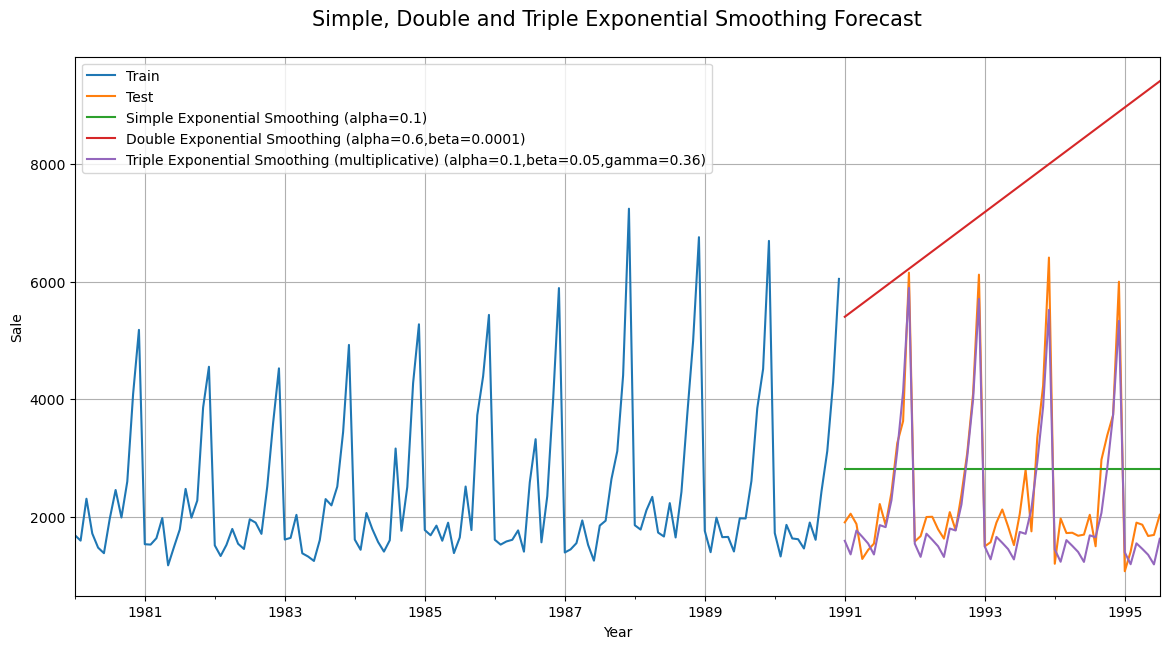

In [59]:
plt.figure(figsize=(14,7))
train["Sparkling"].plot()
test["Sparkling"].plot()
SES_predict.plot()
DES_predict.plot()
TES_predict.plot()
plt.legend(["Train","Test",
            "Simple Exponential Smoothing (alpha=0.1)",
            "Double Exponential Smoothing (alpha=0.6,beta=0.0001)",
            "Triple Exponential Smoothing (multiplicative) (alpha=0.1,beta=0.05,gamma=0.36)"])
plt.title("Simple, Double and Triple Exponential Smoothing Forecast\n",fontsize=15)
plt.xlabel("Year")
plt.ylabel("Sale")
plt.grid()

<b> Model Evaluation

In [60]:
TES_rmse = mean_squared_error(test['Sparkling'],TES_predict.values,squared=False)
print("For Triple Exponential Smoothing Model with multiplicative seasonality forecast on the Test Data,  RMSE is %3.3f" %(TES_rmse))

For Triple Exponential Smoothing Model with multiplicative seasonality forecast on the Test Data,  RMSE is 402.936


In [61]:
rmse_TES = pd.DataFrame([["TripleExponentialSmoothing_multiplicative",round(TES_rmse,2)]],columns=rmse_scores.columns)

rmse_scores = pd.concat([rmse_scores,rmse_TES],ignore_index=True)
rmse_scores = rmse_scores.sort_values(by="RMSE")
rmse_scores

Model     RMSE
9  TripleExponentialSmoothing_multiplicative   402.94
0                       2-PointMovingAverage   813.40
1                       4-PointMovingAverage  1156.59
2                              SimpleAverage  1275.08
3                 SimpleExponentialSmoothing  1338.00
4                       6-PointMovingAverage  1346.28
5                       9-PointMovingAverage  1346.28
6                           LinearRegression  1384.56
7                                      Naive  3864.28
8                 DoubleExponentialSmoothing  5291.88

### Model 8 - Triple Exponential Smoothing (Additive Seasonality)

In [62]:
model_TES_add = ExponentialSmoothing(train["Sparkling"],trend='additive',seasonal='additive',initialization_method='estimated')
model_TES_add = model_TES_add.fit()

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [63]:
model_TES_add.params

{'smoothing_level': 0.11127217693511166,
 'smoothing_trend': 0.012360783126182025,
 'smoothing_seasonal': 0.4607177659431463,
 'damping_trend': nan,
 'initial_level': 2356.5783078812697,
 'initial_trend': -0.018442178724720648,
 'initial_seasons': array([-636.23349205, -722.98346399, -398.64349841, -473.43073157,
        -808.42502897, -815.35019273, -384.23061339,   72.99513671,
        -237.44278517,  272.32607144, 1541.37826596, 2590.07759442]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

<b> The smoothing level ( $\alpha$ ) is taken at around 0.1, the smoothing trend ( $\beta$ ) is taken at approx 0.01 and the smoothing seasonality ( $\gamma$ ) is taken at 0.46.

In [64]:
TES_predict_add =  model_TES_add.forecast(len(test))
TES_predict_add

1991-01-01    1490.574618
1991-02-01    1204.714535
1991-03-01    1688.941336
1991-04-01    1551.451059
1991-05-01    1461.440697
1991-06-01    1278.907452
1991-07-01    1805.164331
1991-08-01    1679.251719
1991-09-01    2315.687997
1991-10-01    3225.309274
1991-11-01    4299.652749
1991-12-01    6411.161831
1992-01-01    1483.297096
1992-02-01    1197.437013
1992-03-01    1681.663814
1992-04-01    1544.173537
1992-05-01    1454.163175
1992-06-01    1271.629930
1992-07-01    1797.886809
1992-08-01    1671.974197
1992-09-01    2308.410475
1992-10-01    3218.031752
1992-11-01    4292.375227
1992-12-01    6403.884309
1993-01-01    1476.019574
1993-02-01    1190.159491
1993-03-01    1674.386292
1993-04-01    1536.896015
1993-05-01    1446.885653
1993-06-01    1264.352408
1993-07-01    1790.609287
1993-08-01    1664.696675
1993-09-01    2301.132953
1993-10-01    3210.754230
1993-11-01    4285.097705
1993-12-01    6396.606787
1994-01-01    1468.742052
1994-02-01    1182.881969
1994-03-01  

#### Plotting the Training data, Test data and the forecasted values

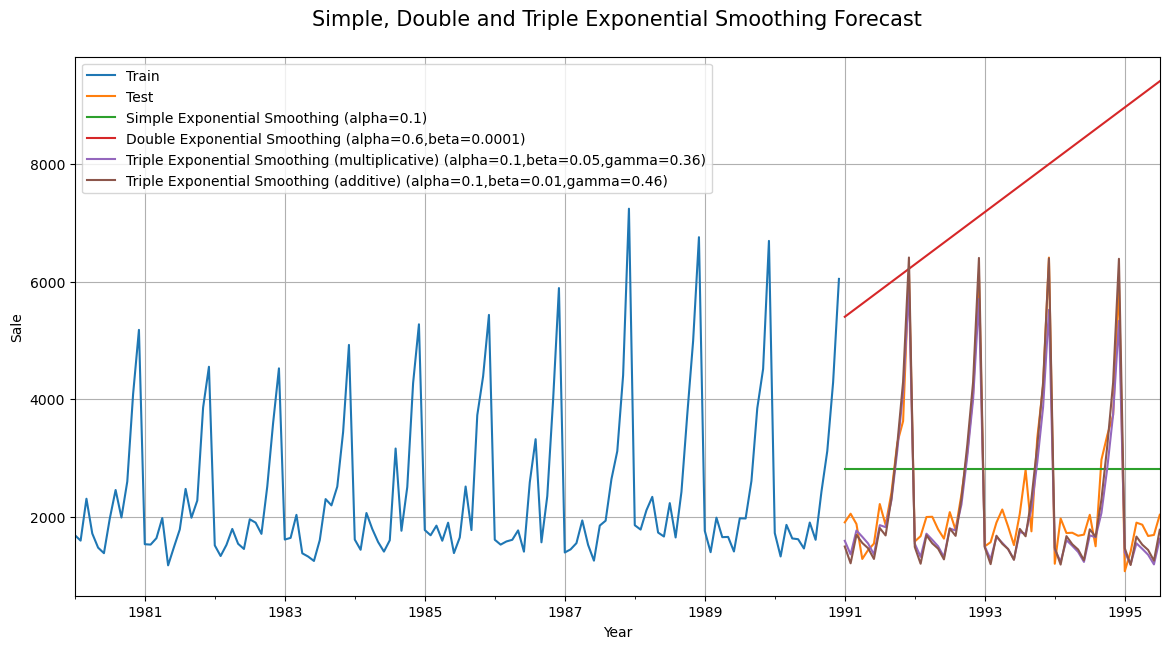

In [65]:
plt.figure(figsize=(14,7))
train["Sparkling"].plot()
test["Sparkling"].plot()
SES_predict.plot()
DES_predict.plot()
TES_predict.plot()
TES_predict_add.plot()
plt.legend(["Train","Test",
            "Simple Exponential Smoothing (alpha=0.1)",
            "Double Exponential Smoothing (alpha=0.6,beta=0.0001)",
            "Triple Exponential Smoothing (multiplicative) (alpha=0.1,beta=0.05,gamma=0.36)",
            "Triple Exponential Smoothing (additive) (alpha=0.1,beta=0.01,gamma=0.46)"])
plt.title("Simple, Double and Triple Exponential Smoothing Forecast\n",fontsize=15)
plt.xlabel("Year")
plt.ylabel("Sale")
plt.grid()

<b> Model Evaluation

In [66]:
TES_rmse_add = mean_squared_error(test['Sparkling'],TES_predict_add.values,squared=False)
print("For Triple Exponential Smoothing Model with an additive seasonality forecast on the Test Data,  RMSE is %3.3f" %(TES_rmse_add))

For Triple Exponential Smoothing Model with an additive seasonality forecast on the Test Data,  RMSE is 378.626


In [67]:
rmse_TES_add = pd.DataFrame([["TripleExponentialSmoothing_additive",round(TES_rmse_add,2)]],columns=rmse_scores.columns)

rmse_scores = pd.concat([rmse_scores,rmse_TES_add],ignore_index=True)
rmse_scores = rmse_scores.sort_values(by="RMSE")
rmse_scores

Model     RMSE
10        TripleExponentialSmoothing_additive   378.63
0   TripleExponentialSmoothing_multiplicative   402.94
1                        2-PointMovingAverage   813.40
2                        4-PointMovingAverage  1156.59
3                               SimpleAverage  1275.08
4                  SimpleExponentialSmoothing  1338.00
5                        6-PointMovingAverage  1346.28
6                        9-PointMovingAverage  1346.28
7                            LinearRegression  1384.56
8                                       Naive  3864.28
9                  DoubleExponentialSmoothing  5291.88

<b> Out of all the models, the Triple Exponential Smoothing model having an additive seasonality has the least RMSE score making it the most preferrable model.

### Stationarity Test

<b> The Stationarity Test is done using the Dickey-Fuller Test which assumes the null-hypothesis (H<sub>0</sub>) of the time series to be non-stationary and the alternate hypothesis (H<sub>a</sub>) to be stationary. This means that if the p-value ($\alpha$) < 0.05, then the null hypothesis is rejected meaning that the time series is stationary else it is accepted meaning that it is non-stationary.

In [68]:
dftest = adfuller(sparkling_df["Sparkling"])#python implementation of dicky fuller test 
dftest
print('DF test statistic is %3.3f' %dftest[0])
print('DF test p-value is %1.4f' %dftest[1])

DF test statistic is -1.360
DF test p-value is 0.6011


<b> It can be seen that the p-value is greater than the alpha value of 0.05 which means that we cannot reject the null hypothesis meaning that the time series is non-stationary. We can proceed by differencing the series to see if this results into making it stationary.

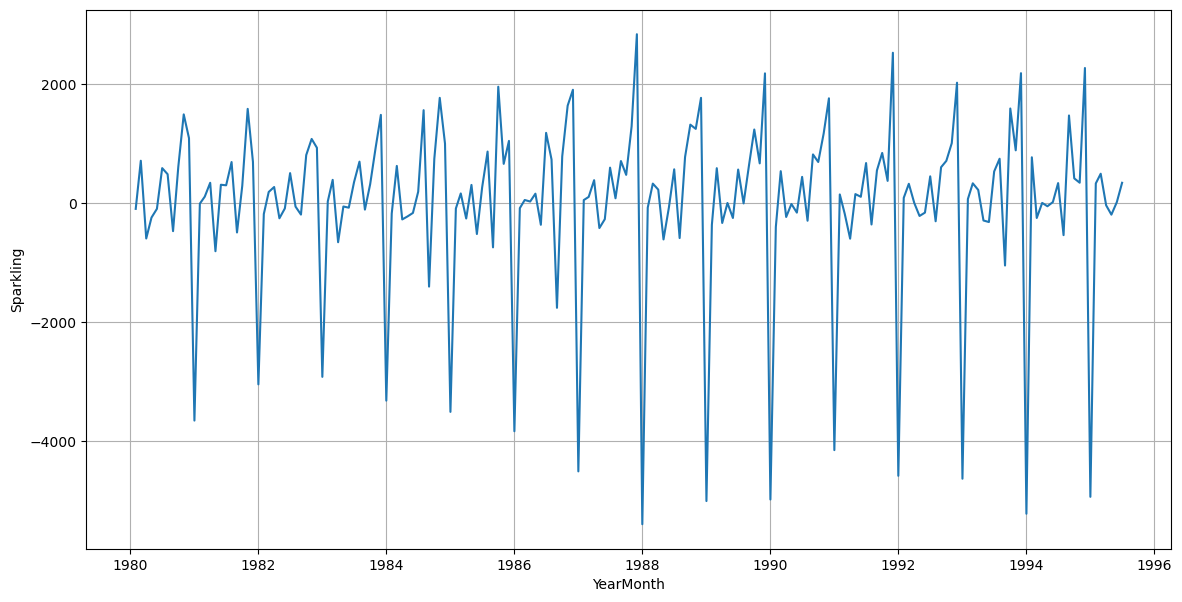

In [69]:
plt.figure(figsize=(14,7))
sns.lineplot(sparkling_df["Sparkling"].diff(periods=1))
plt.grid()

In [70]:
sparkling_diff = sparkling_df["Sparkling"].diff(periods=1)
sparkling_diff = sparkling_diff.dropna()
dftest1 = adfuller(sparkling_diff)
dftest1
print('DF test statistic is %3.3f' %dftest1[0])
print('DF test p-value is %1.4f' %dftest1[1])

DF test statistic is -45.050
DF test p-value is 0.0000


<b> It can be seen that the p-value is less than the alpha value of 0.05 which means that we can reject the null hypothesis meaning that the time series when differenced at (d=1) becomes stationary.

### Model 9 - Auto Regressive Integrated Moving Average (ARIMA) Model

<b> Using the Lowest AIC method to compare different orders of 'p', 'q' and 'd'.

In [71]:
p= range(1,4)  # AR component
q = range(1, 4) # Integrated/Differenced component
d= range(0,2) # MA component 

<b> Parameters (p, d, q) estimation matrix for estimating parameters towards building ARIMA model.

#### Generating the different combinations of p, d and q triplets for ARIMA model building 

In [72]:
pdq = list(itertools.product(p, d, q))

In [73]:
print("ARIMA parameters:\n{}".format(pdq))

ARIMA parameters:
[(1, 0, 1), (1, 0, 2), (1, 0, 3), (1, 1, 1), (1, 1, 2), (1, 1, 3), (2, 0, 1), (2, 0, 2), (2, 0, 3), (2, 1, 1), (2, 1, 2), (2, 1, 3), (3, 0, 1), (3, 0, 2), (3, 0, 3), (3, 1, 1), (3, 1, 2), (3, 1, 3)]


In [74]:
# Creating an empty Dataframe with column names only
ARIMA_AIC = pd.DataFrame(columns=['param', 'AIC'])
ARIMA_AIC

Empty DataFrame
Columns: [param, AIC]
Index: []

In [75]:
for param in pdq:
    ARIMA_model = ARIMA(train.Sparkling,order=param).fit()
    print('ARIMA{} - AIC:{}'.format(param,ARIMA_model.aic))
    ARIMA_AIC = ARIMA_AIC.append({'param':param, 'AIC': ARIMA_model.aic}, ignore_index=True)

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA(1, 0, 1) - AIC:2246.005399728345


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA(1, 0, 2) - AIC:2246.935700452338
ARIMA(1, 0, 3) - AIC:2242.106123411333


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

ARIMA(1, 1, 1) - AIC:2235.7550946734245


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA(1, 1, 2) - AIC:2234.527200452312


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA(1, 1, 3) - AIC:2235.607810648542


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA(2, 0, 1) - AIC:2236.590860178926


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA(2, 0, 2) - AIC:2248.2772806941703


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 

ARIMA(2, 0, 3) - AIC:2205.67317066857
ARIMA(2, 1, 1) - AIC:2233.777626299803


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA(2, 1, 2) - AIC:2213.509212423273


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 

ARIMA(2, 1, 3) - AIC:2232.850547538844
ARIMA(3, 0, 1) - AIC:2248.5628041830114


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA(3, 0, 2) - AIC:2235.1738591138983


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA(3, 0, 3) - AIC:2209.2736536507614
ARIMA(3, 1, 1) - AIC:2235.4991808486548


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 

ARIMA(3, 1, 2) - AIC:2230.8759326916834
ARIMA(3, 1, 3) - AIC:2221.455985112988


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


#### Sorting the above AIC values in the ascending order to get the parameters for the minimum AIC value

In [76]:
ARIMA_AIC.sort_values(by='AIC',ascending=True).head()

param          AIC
8   (2, 0, 3)  2205.673171
14  (3, 0, 3)  2209.273654
10  (2, 1, 2)  2213.509212
17  (3, 1, 3)  2221.455985
16  (3, 1, 2)  2230.875933

<b> Building ARIMA model with best parameters p,d,q for the following values: </b>
  - p = 3
  - d = 0
  - q = 3

In [77]:
best_model = ARIMA(train["Sparkling"],order =(3,0,3))
best_results = best_model.fit()

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [78]:
print(best_results.summary().tables[0])
print(best_results.summary().tables[1])

                               SARIMAX Results                                
Dep. Variable:              Sparkling   No. Observations:                  132
Model:                 ARIMA(3, 0, 3)   Log Likelihood               -1096.637
Date:                Thu, 30 May 2024   AIC                           2209.274
Time:                        23:42:53   BIC                           2232.336
Sample:                    01-01-1980   HQIC                          2218.645
                         - 12-01-1990                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2403.7694    100.044     24.027      0.000    2207.686    2599.852
ar.L1          0.7442      0.226      3.294      0.001       0.301       1.187
ar.L2          0.6991      0.387      1.807      0.0

In [79]:
pred_dynamic = best_results.get_prediction(start=pd.to_datetime('1991-01-01'), dynamic=True, full_results=True)
pred99 = best_results.get_forecast(steps=len(test["Sparkling"]), alpha=0.1)

# Extracting the predicted values of the time series
ARIMA_predict = pred99.predicted_mean
ARIMA_predict

1991-01-01    3133.491922
1991-02-01    2450.963965
1991-03-01    1454.202744
1991-04-01    1026.606353
1991-05-01     669.563050
1991-06-01    1065.878259
1991-07-01    1523.431616
1991-08-01    2485.218858
1991-09-01    3138.761631
1991-10-01    3856.391978
1991-11-01    3920.097039
1991-12-01    3839.140943
1992-01-01    3131.579910
1992-02-01    2487.014099
1992-03-01    1590.726940
1992-04-01    1155.251102
1992-05-01     825.988011
1992-06-01    1140.603170
1992-07-01    1564.374914
1992-08-01    2417.122966
1992-09-01    3044.669294
1992-10-01    3699.291379
1992-11-01    3803.055006
1992-12-01    3732.922554
1993-01-01    3122.166509
1993-02-01    2518.588228
1993-03-01    1710.045611
1993-04-01    1275.194573
1993-05-01     968.224332
1993-06-01    1215.273525
1993-07-01    1603.746909
1993-08-01    2361.498566
1993-09-01    2958.812059
1993-10-01    3558.552974
1993-11-01    3691.923113
1993-12-01    3634.602053
1994-01-01    3106.987947
1994-02-01    2545.695699
1994-03-01  

#### Plotting the Training data, Test data and the forecasted values

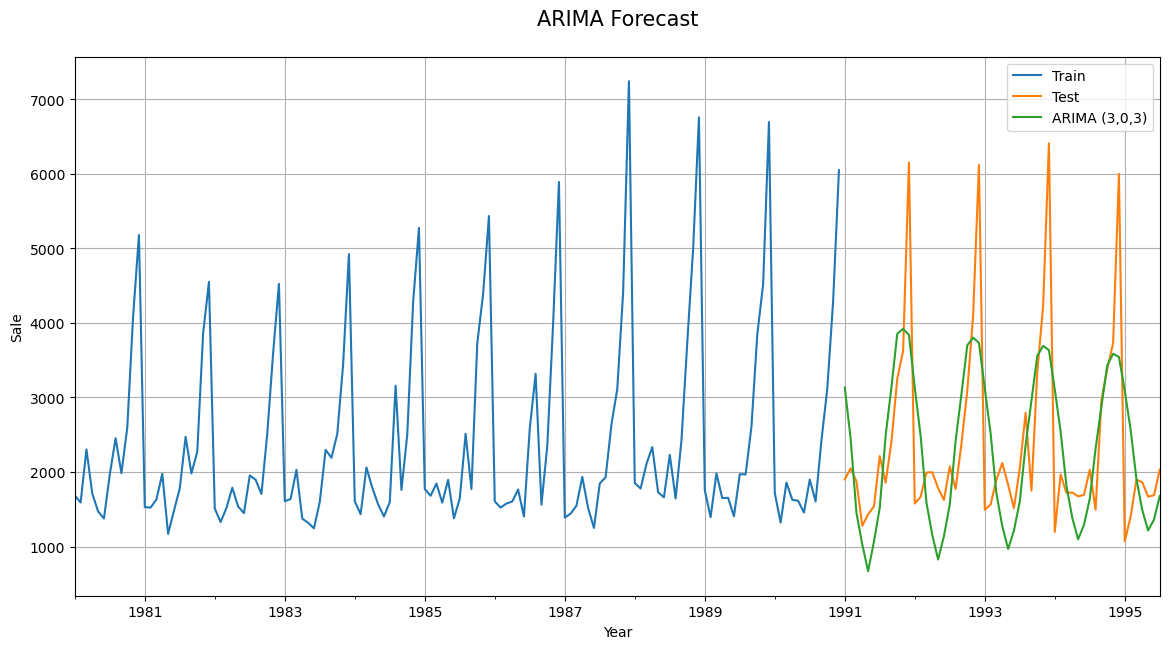

In [80]:
plt.figure(figsize=(14,7))
train["Sparkling"].plot()
test["Sparkling"].plot()
ARIMA_predict.plot()
plt.legend(["Train","Test","ARIMA (3,0,3)"])
plt.title("ARIMA Forecast\n",fontsize=15)
plt.xlabel("Year")
plt.ylabel("Sale")
plt.grid()

<b> Model Evaluation

In [81]:
ARIMA_rmse = mean_squared_error(test['Sparkling'],ARIMA_predict.values,squared=False)
print("For ARIMA forecast on the Test Data,  RMSE is %3.3f" %(ARIMA_rmse))

For ARIMA forecast on the Test Data,  RMSE is 998.612


In [82]:
ARIMA_rmse = pd.DataFrame([["ARIMA (3,0,3)",round(ARIMA_rmse,2)]],columns=rmse_scores.columns)

rmse_scores = pd.concat([rmse_scores,ARIMA_rmse],ignore_index=True)
rmse_scores = rmse_scores.sort_values(by="RMSE")
rmse_scores

Model     RMSE
0         TripleExponentialSmoothing_additive   378.63
1   TripleExponentialSmoothing_multiplicative   402.94
2                        2-PointMovingAverage   813.40
11                              ARIMA (3,0,3)   998.61
3                        4-PointMovingAverage  1156.59
4                               SimpleAverage  1275.08
5                  SimpleExponentialSmoothing  1338.00
6                        6-PointMovingAverage  1346.28
7                        9-PointMovingAverage  1346.28
8                            LinearRegression  1384.56
9                                       Naive  3864.28
10                 DoubleExponentialSmoothing  5291.88

### Model 10 - Seasonal Auto Regressive Integrated Moving Average (SARIMA) Model

<b> Using the Lowest AIC method to compare different orders of 'p', 'q', 'd', 'P', 'Q' and 'D'.

In [83]:
# Generatng the different combinations of seasonal P,D,Q triplets for SARIMA model building
p = range(0,4)
d = range(0,2)
q = range(0,4)

pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print("SARIMA parameters:\n{}".format(seasonal_pdq))

SARIMA parameters:
[(0, 0, 0, 12), (0, 0, 1, 12), (0, 0, 2, 12), (0, 0, 3, 12), (0, 1, 0, 12), (0, 1, 1, 12), (0, 1, 2, 12), (0, 1, 3, 12), (1, 0, 0, 12), (1, 0, 1, 12), (1, 0, 2, 12), (1, 0, 3, 12), (1, 1, 0, 12), (1, 1, 1, 12), (1, 1, 2, 12), (1, 1, 3, 12), (2, 0, 0, 12), (2, 0, 1, 12), (2, 0, 2, 12), (2, 0, 3, 12), (2, 1, 0, 12), (2, 1, 1, 12), (2, 1, 2, 12), (2, 1, 3, 12), (3, 0, 0, 12), (3, 0, 1, 12), (3, 0, 2, 12), (3, 0, 3, 12), (3, 1, 0, 12), (3, 1, 1, 12), (3, 1, 2, 12), (3, 1, 3, 12)]


#### Creating an empty Dataframe with column names only

In [84]:
SARIMA_AIC = pd.DataFrame(columns=['param','seasonal', 'AIC'])
SARIMA_AIC

Empty DataFrame
Columns: [param, seasonal, AIC]
Index: []

In [85]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        SARIMA_model = sm.tsa.statespace.SARIMAX(train["Sparkling"],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False)
            
        results_SARIMA = SARIMA_model.fit(maxiter=1000)
        print('SARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results_SARIMA.aic))
        SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)

SARIMA(0, 0, 0)x(0, 0, 0, 12) - AIC:2447.5387828489993


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA(0, 0, 0)x(0, 0, 1, 12) - AIC:2094.785599289068


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA(0, 0, 0)x(0, 0, 2, 12) - AIC:1815.8304660224478


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA(0, 0, 0)x(0, 0, 3, 12) - AIC:1588.1966198044738
SARIMA(0, 0, 0)x(0, 1, 0, 12) - AIC:1786.4850411919438


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA(0, 0, 0)x(0, 1, 1, 12) - AIC:1596.2586002510814


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA(0, 0, 0)x(0, 1, 2, 12) - AIC:1428.1357423145605


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA(0, 0, 0)x(0, 1, 3, 12) - AIC:1262.0106342523623
SARIMA(0, 0, 0)x(1, 0, 0, 12) - AIC:1802.3841958898233


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA(0, 0, 0)x(1, 0, 1, 12) - AIC:1763.3466746401891


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA(0, 0, 0)x(1, 0, 2, 12) - AIC:1596.091567172486


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA(0, 0, 0)x(1, 0, 3, 12) - AIC:1427.9282118285155
SARIMA(0, 0, 0)x(1, 1, 0, 12) - AIC:1615.044590751547


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA(0, 0, 0)x(1, 1, 1, 12) - AIC:1598.2582086863779


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA(0, 0, 0)x(1, 1, 2, 12) - AIC:1429.7362167377617


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA(0, 0, 0)x(1, 1, 3, 12) - AIC:1259.3099942381143
SARIMA(0, 0, 0)x(2, 0, 0, 12) - AIC:1616.3804986882144


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA(0, 0, 0)x(2, 0, 1, 12) - AIC:1612.0535698148926


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA(0, 0, 0)x(2, 0, 2, 12) - AIC:1601.0676069890123


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA(0, 0, 0)x(2, 0, 3, 12) - AIC:1458.2787533239914


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA(0, 0, 0)x(2, 1, 0, 12) - AIC:1441.2182003596358


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA(0, 0, 0)x(2, 1, 1, 12) - AIC:1443.0752316020585


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA(0, 0, 0)x(2, 1, 2, 12) - AIC:1429.132845795573


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA(0, 0, 0)x(2, 1, 3, 12) - AIC:1258.872804616757


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA(0, 0, 0)x(3, 0, 0, 12) - AIC:1439.1849370925997


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA(0, 0, 0)x(3, 0, 1, 12) - AIC:1440.028931930299


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA(0, 0, 0)x(3, 0, 2, 12) - AIC:1441.8755361400417


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA(0, 0, 0)x(3, 0, 3, 12) - AIC:1432.642730526635
SARIMA(0, 0, 0)x(3, 1, 0, 12) - AIC:1269.7700147845285


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA(0, 0, 0)x(3, 1, 1, 12) - AIC:1271.2848517722784


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA(0, 0, 0)x(3, 1, 2, 12) - AIC:1270.7619010625658


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA(0, 0, 0)x(3, 1, 3, 12) - AIC:1259.9451817773088
SARIMA(0, 0, 1)x(0, 0, 0, 12) - AIC:2337.10701588418


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA(0, 0, 1)x(0, 0, 1, 12) - AIC:2007.1951040721483


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA(0, 0, 1)x(0, 0, 2, 12) - AIC:1745.4278451969108


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA(0, 0, 1)x(0, 0, 3, 12) - AIC:1533.0183556305647
SARIMA(0, 0, 1)x(0, 1, 0, 12) - AIC:1767.392057745747


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA(0, 0, 1)x(0, 1, 1, 12) - AIC:1577.8120189648348


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA(0, 0, 1)x(0, 1, 2, 12) - AIC:1410.1567223892864


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA(0, 0, 1)x(0, 1, 3, 12) - AIC:1239.0349233447


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA(0, 0, 1)x(1, 0, 0, 12) - AIC:1797.4983102825256


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA(0, 0, 1)x(1, 0, 1, 12) - AIC:1748.1796802734455


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA(0, 0, 1)x(1, 0, 2, 12) - AIC:1580.3707839507388


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA(0, 0, 1)x(1, 0, 3, 12) - AIC:1446.2322250348366


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA(0, 0, 1)x(1, 1, 0, 12) - AIC:1610.5860755335298


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA(0, 0, 1)x(1, 1, 1, 12) - AIC:1579.6084311462864


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA(0, 0, 1)x(1, 1, 2, 12) - AIC:1411.8978058820744


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA(0, 0, 1)x(1, 1, 3, 12) - AIC:1240.9340216859277


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA(0, 0, 1)x(2, 0, 0, 12) - AIC:1612.3592687581654


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA(0, 0, 1)x(2, 0, 1, 12) - AIC:1609.5847959096272


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA(0, 0, 1)x(2, 0, 2, 12) - AIC:1696.2782123726774


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA(0, 0, 1)x(2, 0, 3, 12) - AIC:1418.690846199148


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA(0, 0, 1)x(2, 1, 0, 12) - AIC:1437.6156704924294


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA(0, 0, 1)x(2, 1, 1, 12) - AIC:1439.5176118914997


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA(0, 0, 1)x(2, 1, 2, 12) - AIC:1412.4228270149056


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA(0, 0, 1)x(2, 1, 3, 12) - AIC:1240.542277178078


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA(0, 0, 1)x(3, 0, 0, 12) - AIC:1437.283469899532


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA(0, 0, 1)x(3, 0, 1, 12) - AIC:1450.8957572162944


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA(0, 0, 1)x(3, 0, 2, 12) - AIC:1440.463332060499


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA(0, 0, 1)x(3, 0, 3, 12) - AIC:1410.4732135374159


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA(0, 0, 1)x(3, 1, 0, 12) - AIC:1266.422825823037


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA(0, 0, 1)x(3, 1, 1, 12) - AIC:1268.2420620225018


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA(0, 0, 1)x(3, 1, 2, 12) - AIC:1268.377427073891


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA(0, 0, 1)x(3, 1, 3, 12) - AIC:1241.0163523899628
SARIMA(0, 0, 2)x(0, 0, 0, 12) - AIC:2278.506916995601


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA(0, 0, 2)x(0, 0, 1, 12) - AIC:1969.3439982451405


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA(0, 0, 2)x(0, 0, 2, 12) - AIC:1718.5070176998297


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA(0, 0, 2)x(0, 0, 3, 12) - AIC:1511.713521307843
SARIMA(0, 0, 2)x(0, 1, 0, 12) - AIC:1752.5326097680593


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA(0, 0, 2)x(0, 1, 1, 12) - AIC:1566.0280736699951


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA(0, 0, 2)x(0, 1, 2, 12) - AIC:1396.9872517791498


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA(0, 0, 2)x(0, 1, 3, 12) - AIC:1226.9364934244386


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA(0, 0, 2)x(1, 0, 0, 12) - AIC:1799.197257606934


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA(0, 0, 2)x(1, 0, 1, 12) - AIC:1734.4038429879065


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA(0, 0, 2)x(1, 0, 2, 12) - AIC:1568.059980724618


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA(0, 0, 2)x(1, 0, 3, 12) - AIC:1442.0270335677305


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA(0, 0, 2)x(1, 1, 0, 12) - AIC:1612.0322933662924


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA(0, 0, 2)x(1, 1, 1, 12) - AIC:1568.0079279044728


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA(0, 0, 2)x(1, 1, 2, 12) - AIC:1398.924567558459


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA(0, 0, 2)x(1, 1, 3, 12) - AIC:1228.8523716322372


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA(0, 0, 2)x(2, 0, 0, 12) - AIC:1613.7631444878705


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA(0, 0, 2)x(2, 0, 1, 12) - AIC:1744.7413511595742


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


KeyboardInterrupt: 

#### Sorting the above AIC values in the ascending order to get the parameters for the minimum AIC value

In [86]:
SARIMA_AIC.sort_values(by='AIC',ascending=True).head(10)

param       seasonal          AIC
71  (0, 0, 2)  (0, 1, 3, 12)  1226.936493
79  (0, 0, 2)  (1, 1, 3, 12)  1228.852372
39  (0, 0, 1)  (0, 1, 3, 12)  1239.034923
55  (0, 0, 1)  (2, 1, 3, 12)  1240.542277
47  (0, 0, 1)  (1, 1, 3, 12)  1240.934022
63  (0, 0, 1)  (3, 1, 3, 12)  1241.016352
23  (0, 0, 0)  (2, 1, 3, 12)  1258.872805
15  (0, 0, 0)  (1, 1, 3, 12)  1259.309994
31  (0, 0, 0)  (3, 1, 3, 12)  1259.945182
7   (0, 0, 0)  (0, 1, 3, 12)  1262.010634

* Criteria to choose the best fit model is the lowest/minimum AIC value

Hence the following values would be used for the SARIMAX model which has the least AIC of (value):

- p = non-seasonal AR order = 2,
- d = non-seasonal differencing = 1,
- q = non-seasonal MA order = 3,
- P = seasonal AR order = 0,
- D = seasonal differencing = 1,
- Q = seasonal MA order = 3,
- S = time span of repeating seasonal pattern = 12

<b> Building SARIMA model with the best parameters.

In [87]:
best_model = sm.tsa.statespace.SARIMAX(train["Sparkling"],
                                            order=(2,1,3),
                                            seasonal_order=(0,1,3,12),
                                            enforce_stationarity=False)
best_results = best_model.fit()

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [88]:
print(best_results.summary().tables[0])
print(best_results.summary().tables[1])

                                     SARIMAX Results                                      
Dep. Variable:                          Sparkling   No. Observations:                  132
Model:             SARIMAX(2, 1, 3)x(0, 1, 3, 12)   Log Likelihood                -589.788
Date:                            Thu, 30 May 2024   AIC                           1197.576
Time:                                    23:46:04   BIC                           1218.901
Sample:                                01-01-1980   HQIC                          1206.120
                                     - 12-01-1990                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.6310      0.140    -11.662      0.000      -1.905      -1.357
ar.L2         -0.6513      0.137   

In [89]:
pred_dynamic = best_results.get_prediction(start=pd.to_datetime('1991-01-01'), dynamic=True, full_results=True)
pred99 = best_results.get_forecast(steps=len(test["Sparkling"]), alpha=0.1)

#### Extracting the predicted and true values of our time series

In [90]:
SARIMA_predict = pred99.predicted_mean
SARIMA_predict

1991-01-01    1551.915690
1991-02-01    1394.433062
1991-03-01    1799.088485
1991-04-01    1671.989222
1991-05-01    1575.707859
1991-06-01    1369.323732
1991-07-01    1917.614251
1991-08-01    1660.936753
1991-09-01    2400.843897
1991-10-01    3237.060986
1991-11-01    4379.688343
1991-12-01    6225.966010
1992-01-01    1581.633980
1992-02-01    1305.892998
1992-03-01    1795.991071
1992-04-01    1605.795412
1992-05-01    1552.330919
1992-06-01    1314.518887
1992-07-01    1885.906603
1992-08-01    1626.122762
1992-09-01    2371.831482
1992-10-01    3218.757223
1992-11-01    4346.874047
1992-12-01    6205.761823
1993-01-01    1547.365376
1993-02-01    1261.793432
1993-03-01    1757.486376
1993-04-01    1563.167856
1993-05-01    1512.953816
1993-06-01    1276.903544
1993-07-01    1844.380298
1993-08-01    1581.265273
1993-09-01    2331.394765
1993-10-01    3171.602483
1993-11-01    4302.392182
1993-12-01    6156.221599
1994-01-01    1504.879259
1994-02-01    1223.867323
1994-03-01  

#### Plotting the Training data, Test data and the forecasted values

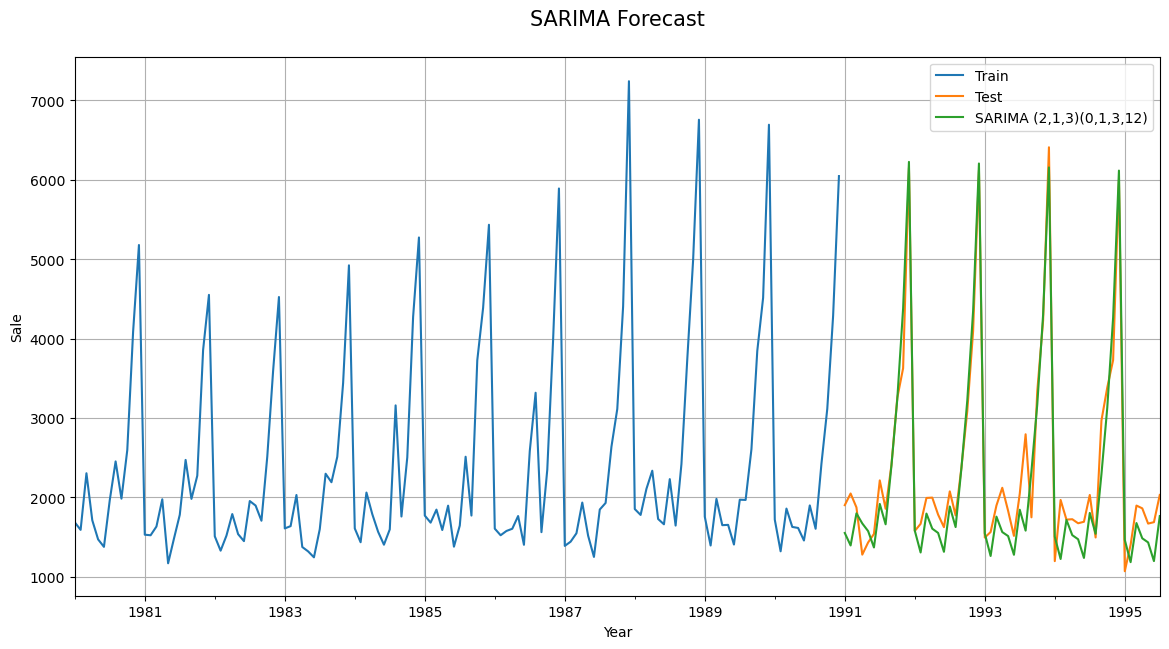

In [91]:
plt.figure(figsize=(14,7))
train["Sparkling"].plot()
test["Sparkling"].plot()
SARIMA_predict.plot()
plt.legend(["Train","Test","SARIMA (2,1,3)(0,1,3,12)"])
plt.title("SARIMA Forecast\n",fontsize=15)
plt.xlabel("Year")
plt.ylabel("Sale")
plt.grid()

<b> Model Evaluation

In [92]:
SARIMA_rmse = mean_squared_error(test['Sparkling'],SARIMA_predict.values,squared=False)
print("For SARIMA forecast on the Test Data,  RMSE is %3.3f" %(SARIMA_rmse))

For SARIMA forecast on the Test Data,  RMSE is 361.417


In [93]:
SARIMA_rmse = pd.DataFrame([["SARIMA (2,1,3)(0,1,3,12)",round(SARIMA_rmse,2)]],columns=rmse_scores.columns)

rmse_scores = pd.concat([rmse_scores,SARIMA_rmse],ignore_index=True)
rmse_scores = rmse_scores.sort_values(by="RMSE")
rmse_scores

Model     RMSE
12                   SARIMA (2,1,3)(0,1,3,12)   361.42
0         TripleExponentialSmoothing_additive   378.63
1   TripleExponentialSmoothing_multiplicative   402.94
2                        2-PointMovingAverage   813.40
3                               ARIMA (3,0,3)   998.61
4                        4-PointMovingAverage  1156.59
5                               SimpleAverage  1275.08
6                  SimpleExponentialSmoothing  1338.00
7                        6-PointMovingAverage  1346.28
8                        9-PointMovingAverage  1346.28
9                            LinearRegression  1384.56
10                                      Naive  3864.28
11                 DoubleExponentialSmoothing  5291.88

<b> It can be observed from the RMSE scores that of all models, the SARIMA model has the least RMSE score hence making it the most appropriate model for forecasting.

### Building the Optimum Model for Forecasting

### Getting the forecast of 12 steps (1 year) ahead in future

In [94]:
pred_uc_99 = best_results.get_forecast(steps=12, alpha=0.01) # alpha=0.01 signifies 99% confidence interval
pred_uc_95 = best_results.get_forecast(steps=12, alpha=0.05) # alpha=0.05 95% CI

### Getting confidence intervals 95% & 99% of the forecasts

In [95]:
pred_ci_99 = pred_uc_99.conf_int()
pred_ci_95 = pred_uc_95.conf_int()

idx = pd.date_range(start='1995-08-01',end='1996-07-01',freq='MS')

fc_95 = pd.DataFrame(np.column_stack([pred_uc_95.predicted_mean, pred_ci_95]), 
                     index=idx, columns=['forecast', 'lower_ci_95', 'upper_ci_95'])

fc_99 = pd.DataFrame(np.column_stack([pred_ci_99]), 
                     index=idx, columns=['lower_ci_99', 'upper_ci_99'])

fc_all = fc_95.combine_first(fc_99)
fc_all = fc_all[['forecast', 'lower_ci_95', 'upper_ci_95', 'lower_ci_99', 'upper_ci_99']] # Reordering columns
fc_all.head()

forecast  lower_ci_95  upper_ci_95  lower_ci_99  upper_ci_99
1995-08-01  1551.915690   709.058418  2394.772963   709.058418  2394.772963
1995-09-01  1394.433062   495.716059  2293.150065   495.716059  2293.150065
1995-10-01  1799.088485   894.477374  2703.699596   894.477374  2703.699596
1995-11-01  1671.989222   753.286792  2590.691652   753.286792  2590.691652
1995-12-01  1575.707859   657.005718  2494.410000   657.005718  2494.410000

#### Plotting the forecast along with the confidence band

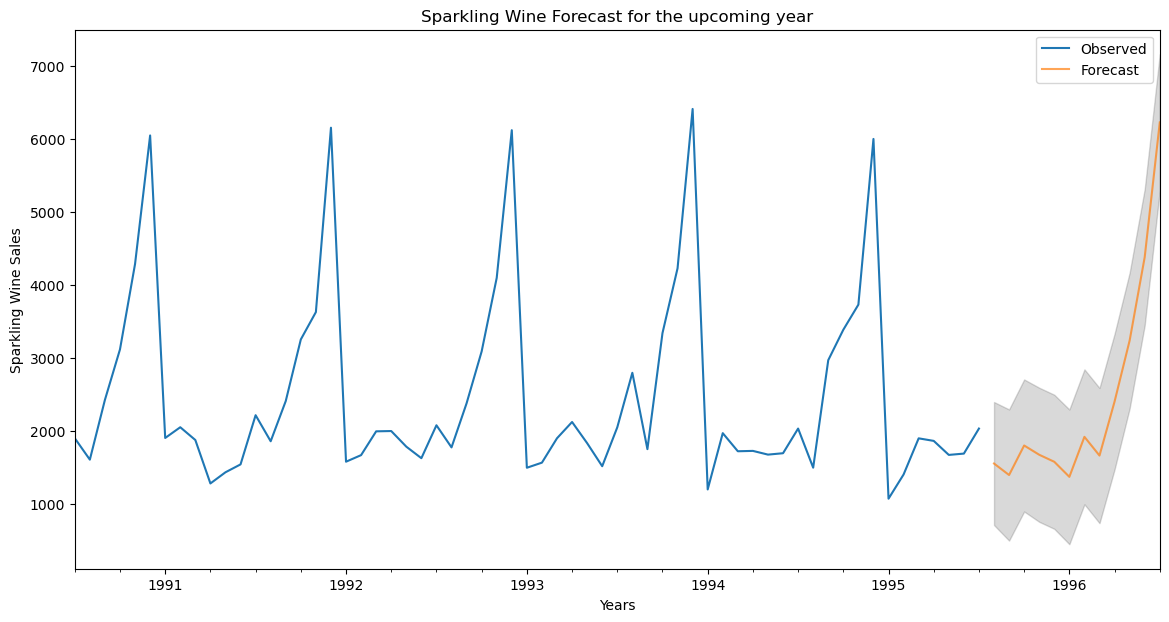

In [96]:
axis = sparkling_df["Sparkling"].iloc[126:].plot(label='Observed', figsize=(14,7))
fc_all['forecast'].plot(ax=axis, label='Forecast', alpha=0.7)
axis.fill_between(fc_all.index, fc_all['lower_ci_95'], fc_all['upper_ci_95'], color='k', alpha=0.15)
axis.set_xlabel('Years')
axis.set_ylabel('Sparkling Wine Sales')
plt.title("Sparkling Wine Forecast for the upcoming year")
plt.legend(loc='best')
plt.show()

#### Ploting ACF and PACF for residuals of ARIMA model to ensure no more information is left for extraction

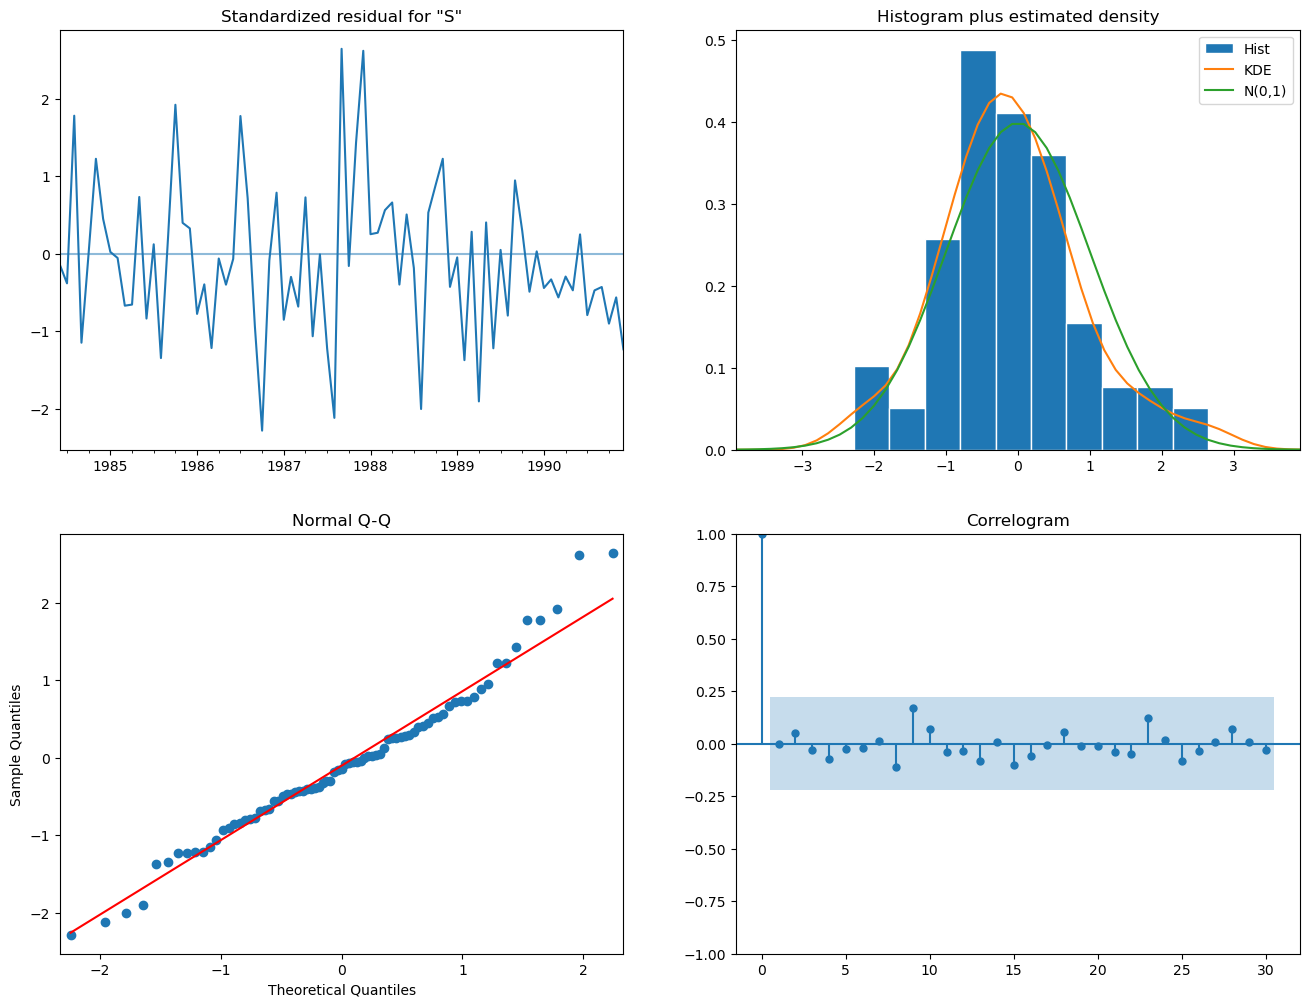

In [97]:
best_results.plot_diagnostics(lags=30, figsize=(16,12))
plt.show()

# END 